# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.9 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 102.6 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2024

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Parameters:
    dcor_df : pandas.DataFrame
        The distance correlation matrix as a pandas DataFrame.

    Returns:
    Histogram plot of the correlatons.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates 10 bins with edges at 0, 0.1, 0.2, ..., 1.0
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")


**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
variable_rename = {
    'Attribute1': 'Status_of_existing_checking_account',
    'Attribute2': 'Duration',
    'Attribute3': 'Credit_history',
    'Attribute4': 'Purpose',
    'Attribute5': 'Credit_amount',
    'Attribute6': 'Savings_account_bonds',
    'Attribute7': 'Present_employment_since',
    'Attribute8': 'Installment_rate_in_percentage_of_disposable_income',
    'Attribute9': 'Personal_status_and_sex',
    'Attribute10': 'Other_debtors_guarantors',
    'Attribute11': 'Present_residence_since',
    'Attribute12': 'Property',
    'Attribute13': 'Age',
    'Attribute14': 'Other_installment_plans',
    'Attribute15': 'Housing',
    'Attribute16': 'Number_of_existing_credits_at_this_bank',
    'Attribute17': 'Job',
    'Attribute18': 'Number_of_people_being_liable_to_provide_maintenance_for',
    'Attribute19': 'Telephone',
    'Attribute20': 'Foreign_worker',
    'class': 'Target'
}

german_credit, german_variables = load_data_from_ucimlrepo(144, variable_rename_dict=variable_rename)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [ ]:
german_credit.head()

Status_of_existing_checking_account  Duration Credit_history Purpose  \
0                                 A11         6            A34     A43   
1                                 A12        48            A32     A43   
2                                 A14        12            A34     A46   
3                                 A11        42            A32     A42   
4                                 A11        24            A33     A40   

   Credit_amount Savings_account_bonds Present_employment_since  \
0           1169                   A65                      A75   
1           5951                   A61                      A73   
2           2096                   A61                      A74   
3           7882                   A61                      A74   
4           4870                   A61                      A73   

   Installment_rate_in_percentage_of_disposable_income  \
0                                                  4     
1                                                  2     
2                                                  2     
3                                                  2     
4                                                  3     

  Personal_status_and_sex Other_debtors_guarantors  ...  Property Age  \
0                     A93                     A101  ...      A121  67   
1                     A92                     A101  ...      A121  22   
2                     A93                     A101  ...      A121  49   
3                     A93                     A103  ...      A122  45   
4                     A93                     A101  ...      A124  53   

   Other_installment_plans Housing Number_of_existing_credits_at_this_bank  \
0                     A143    A152                                       2   
1                     A143    A152                                       1   
2                     A143    A152                                       1   
3                     A143    A153                                       1   
4                     A143    A153                                       2   

    Job Number_of_people_being_liable_to_provide_maintenance_for  Telephone  \
0  A173                                                  1             A192   
1  A173                                                  1             A191   
2  A172                                                  2             A191   
3  A173                                                  2             A191   
4  A173                                                  2             A191   

  Foreign_worker Target  
0           A201      1  
1           A201      2  
2           A201      1  
3           A201      1  
4           A201      2  

[5 rows x 21 columns]

In [ ]:
german_variables

name     role         type  \
0                 Status_of_existing_checking_account  Feature  Categorical   
1                                            Duration  Feature      Integer   
2                                      Credit_history  Feature  Categorical   
3                                             Purpose  Feature  Categorical   
4                                       Credit_amount  Feature      Integer   
5                               Savings_account_bonds  Feature  Categorical   
6                            Present_employment_since  Feature  Categorical   
7   Installment_rate_in_percentage_of_disposable_i...  Feature      Integer   
8                             Personal_status_and_sex  Feature  Categorical   
9                            Other_debtors_guarantors  Feature  Categorical   
10                            Present_residence_since  Feature      Integer   
11                                           Property  Feature  Categorical   
12                                                Age  Feature      Integer   
13                            Other_installment_plans  Feature  Categorical   
14                                            Housing  Feature  Categorical   
15            Number_of_existing_credits_at_this_bank  Feature      Integer   
16                                                Job  Feature  Categorical   
17  Number_of_people_being_liable_to_provide_maint...  Feature      Integer   
18                                          Telephone  Feature       Binary   
19                                     Foreign_worker  Feature       Binary   
20                                             Target   Target       Binary   

       demographic                                        description   units  \
0             None                Status of existing checking account    None   
1             None                                           Duration  months   
2             None                                     Credit history    None   
3             None                                            Purpose    None   
4             None                                      Credit amount    None   
5             None                              Savings account/bonds    None   
6            Other                           Present employment since    None   
7             None  Installment rate in percentage of disposable i...    None   
8   Marital Status                            Personal status and sex    None   
9             None                         Other debtors / guarantors    None   
10            None                            Present residence since    None   
11            None                                           Property    None   
12             Age                                                Age   years   
13            None                            Other installment plans    None   
14           Other                                            Housing    None   
15            None            Number of existing credits at this bank    None   
16      Occupation                                                Job    None   
17            None  Number of people being liable to provide maint...    None   
18            None                                          Telephone    None   
19           Other                                     foreign worker    None   
20            None                                  1 = Good, 2 = Bad    None   

   missing_values  
0              no  
1              no  
2              no  
3              no  
4              no  
5              no  
6              no  
7              no  
8              no  
9              no  
10             no  
11             no  
12             no  
13             no  
14             no  
15             no  
16             no  
17             no  
18             no  
19             no  
20             no

## Make feature names and feature values more human-interpretable

In [ ]:
# Dictionaries for each categorical attribute
Status_of_existing_checking_account = {
    'A11': 'less than 0 DM',
    'A12': 'from 0 to 200 DM',
    'A13': 'greater or equal to 200 DM or salary assignments',
    'A14': 'no checking account'
}

Credit_history = {
    'A30': 'no credits taken or all credits paid back duly',
    'A31': 'all credits at this bank paid back duly',
    'A32': 'existing credits paid back duly till now',
    'A33': 'delay in paying off in the past',
    'A34': 'critical account or other credits existing'
}

Purpose = {
    'A40': 'car new',
    'A41': 'car used',
    'A42': 'furniture or equipment',
    'A43': 'radio or television',
    'A44': 'domestic appliances',
    'A45': 'repairs',
    'A46': 'education',
    'A48': 'retraining',
    'A49': 'business',
    'A410': 'others'
}

Savings_account_bonds = {
    'A61': 'less than 100 DM',
    'A62': 'from 100 to 500 DM',
    'A63': 'from 500 to 1000 DM',
    'A64': 'greater or equal to 1000 DM',
    'A65': 'unknown/no savings account'
}

Present_employment_since = {
    'A71': 'unemployed',
    'A72': 'less than 1 year',
    'A73': 'from 1 to 4 years',
    'A74': 'from 4 to 7 years',
    'A75': 'greater or equal to 7 years'
}

Personal_status_and_sex = {
    'A91': 'male divorced or separated',
    'A92': 'female divorced or separated or married',
    'A93': 'male single',
    'A94': 'male married or widowed',
    'A95': 'female single'
}

Other_debtors_guarantors = {
    'A101': 'none',
    'A102': 'co-applicant',
    'A103': 'guarantor'
}

Property = {
    'A121': 'real estate',
    'A122': 'building society savings or agreement or life insurance',
    'A123': 'car or other',
    'A124': 'unknown or no property'
}

Other_installment_plans = {
    'A141': 'bank',
    'A142': 'stores',
    'A143': 'none'
}

Housing = {
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free'
}

Job = {
    'A171': 'unemployed or unskilled - non-resident',
    'A172': 'unskilled - resident',
    'A173': 'skilled employee or official',
    'A174': 'management or self-employed or highly qualified employee or officer'
}

Telephone = {
    'A191': 'no',
    'A192': 'yes'
}

Foreign_worker = {
    'A201': 'yes',
    'A202': 'no'
}

Target = {
    1: 'good',
    2: 'bad'
}

# Dictionary mapping attributes to their respective mapping dictionaries
attribute_mappings = {
    'Status_of_existing_checking_account': Status_of_existing_checking_account,
    'Credit_history': Credit_history,
    'Purpose': Purpose,
    'Savings_account_bonds': Savings_account_bonds,
    'Present_employment_since': Present_employment_since,
    'Personal_status_and_sex': Personal_status_and_sex,
    'Other_debtors_guarantors': Other_debtors_guarantors,
    'Property': Property,
    'Other_installment_plans': Other_installment_plans,
    'Housing': Housing,
    'Job': Job,
    'Telephone': Telephone,
    'Foreign_worker': Foreign_worker,
    'Target': Target
}

# Apply the mappings to the DataFrame:
for column, mapping in attribute_mappings.items():
    german_credit[column] = german_credit[column].map(mapping)

german_credit.head()

Status_of_existing_checking_account  Duration  \
0                      less than 0 DM         6   
1                    from 0 to 200 DM        48   
2                 no checking account        12   
3                      less than 0 DM        42   
4                      less than 0 DM        24   

                               Credit_history                 Purpose  \
0  critical account or other credits existing     radio or television   
1    existing credits paid back duly till now     radio or television   
2  critical account or other credits existing               education   
3    existing credits paid back duly till now  furniture or equipment   
4             delay in paying off in the past                 car new   

   Credit_amount       Savings_account_bonds     Present_employment_since  \
0           1169  unknown/no savings account  greater or equal to 7 years   
1           5951            less than 100 DM            from 1 to 4 years   
2           2096            less than 100 DM            from 4 to 7 years   
3           7882            less than 100 DM            from 4 to 7 years   
4           4870            less than 100 DM            from 1 to 4 years   

   Installment_rate_in_percentage_of_disposable_income  \
0                                                  4     
1                                                  2     
2                                                  2     
3                                                  2     
4                                                  3     

                   Personal_status_and_sex Other_debtors_guarantors  ...  \
0                              male single                     none  ...   
1  female divorced or separated or married                     none  ...   
2                              male single                     none  ...   
3                              male single                guarantor  ...   
4                              male single                     none  ...   

                                            Property Age  \
0                                        real estate  67   
1                                        real estate  22   
2                                        real estate  49   
3  building society savings or agreement or life ...  45   
4                             unknown or no property  53   

   Other_installment_plans   Housing Number_of_existing_credits_at_this_bank  \
0                     none       own                                       2   
1                     none       own                                       1   
2                     none       own                                       1   
3                     none  for free                                       1   
4                     none  for free                                       2   

                            Job  \
0  skilled employee or official   
1  skilled employee or official   
2          unskilled - resident   
3  skilled employee or official   
4  skilled employee or official   

  Number_of_people_being_liable_to_provide_maintenance_for  Telephone  \
0                                                  1              yes   
1                                                  1               no   
2                                                  2               no   
3                                                  2               no   
4                                                  2               no   

  Foreign_worker Target  
0            yes   good  
1            yes    bad  
2            yes   good  
3            yes   good  
4            yes    bad  

[5 rows x 21 columns]

# **Split data in train and test set**

In [ ]:
german_credit_train, german_credit_test = train_test_split(
    german_credit, test_size=0.2, random_state=RANDOM_STATE,
    stratify=german_credit["Target"]
)
german_credit_train['Target'].value_counts()

Target
good    560
bad     240
Name: count, dtype: int64

## Variable encoding

In [ ]:
cat_variables = (
    list(german_variables[german_variables['type']=='Binary']['name']) +
    list(german_variables[german_variables['type']=='Categorical']['name'])
)

if 'Target' in cat_variables:
  cat_variables.remove('Target')

print('Categorical variables: ', cat_variables)

# Apply the encoding function
german_credit_train_encoded, german_ohe = one_hot_encoding(german_credit_train, cat_variables, encoder=None)
german_credit_test_encoded, _ = one_hot_encoding(german_credit_test, cat_variables, encoder=german_ohe)

# Traget variable encoding for the project 0: "Good" and 1: "Bad", useful for F1 calculation
Target_encoder = {
    'good': 0.0,
    'bad': 1.0
}
german_credit_train_encoded = encode_binary_variables(german_credit_train_encoded, ['Target'], Target_encoder)
german_credit_test_encoded = encode_binary_variables(german_credit_test_encoded, ['Target'], Target_encoder)

# move target variable to the end of the dataframe
X_vars = [col for col in german_credit_train_encoded.columns if col != 'Target']
german_credit_train_encoded = german_credit_train_encoded[X_vars + ['Target']]
german_credit_test_encoded = german_credit_test_encoded[X_vars + ['Target']]

german_encoded_vars_family = map_encoded_variables_to_original(german_credit_train_encoded.columns, cat_variables)

Categorical variables:  ['Telephone', 'Foreign_worker', 'Status_of_existing_checking_account', 'Credit_history', 'Purpose', 'Savings_account_bonds', 'Present_employment_since', 'Personal_status_and_sex', 'Other_debtors_guarantors', 'Property', 'Other_installment_plans', 'Housing', 'Job']


In [ ]:
german_credit_train_encoded.head()

Duration  Credit_amount  \
254         9           2030   
413        10           1597   
465        24           2924   
188        12            674   
724        27           2570   

     Installment_rate_in_percentage_of_disposable_income  \
254                                                  2     
413                                                  3     
465                                                  3     
188                                                  4     
724                                                  3     

     Present_residence_since  Age  Number_of_existing_credits_at_this_bank  \
254                        1   24                                        1   
413                        2   40                                        1   
465                        4   63                                        1   
188                        1   20                                        1   
724                        3   21                                        1   

     Number_of_people_being_liable_to_provide_maintenance_for  Telephone_yes  \
254                                                  1                   1.0   
413                                                  2                   0.0   
465                                                  2                   1.0   
188                                                  1                   0.0   
724                                                  1                   0.0   

     Foreign_worker_yes  \
254                 1.0   
413                 0.0   
465                 1.0   
188                 1.0   
724                 1.0   

     Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments  \
254                                                0.0                                      
413                                                0.0                                      
465                                                0.0                                      
188                                                0.0                                      
724                                                0.0                                      

     ...  Property_real estate  Property_unknown or no property  \
254  ...                   0.0                              0.0   
413  ...                   0.0                              1.0   
465  ...                   0.0                              1.0   
188  ...                   0.0                              0.0   
724  ...                   1.0                              0.0   

     Other_installment_plans_none  Other_installment_plans_stores  \
254                           1.0                             0.0   
413                           1.0                             0.0   
465                           0.0                             0.0   
188                           1.0                             0.0   
724                           1.0                             0.0   

     Housing_own  Housing_rent  Job_skilled employee or official  \
254          1.0           0.0                               1.0   
413          0.0           1.0                               0.0   
465          1.0           0.0                               1.0   
188          1.0           0.0                               1.0   
724          0.0           1.0                               1.0   

     Job_unemployed or unskilled - non-resident  Job_unskilled - resident  \
254                                         0.0                       0.0   
413                                         0.0                       1.0   
465                                         0.0                       0.0   
188                                         0.0                       0.0   
724                                         0.0                       0.0   

     Target  
254     0.0  
413     0.0  
465     0.0  
188     1.0  
724     1.0  

[5 r

In [ ]:
german_credit_train_encoded.columns

Index(['Duration', 'Credit_amount',
       'Installment_rate_in_percentage_of_disposable_income',
       'Present_residence_since', 'Age',
       'Number_of_existing_credits_at_this_bank',
       'Number_of_people_being_liable_to_provide_maintenance_for',
       'Telephone_yes', 'Foreign_worker_yes',
       'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
       'Status_of_existing_checking_account_less than 0 DM',
       'Status_of_existing_checking_account_no checking account',
       'Credit_history_critical account or other credits existing',
       'Credit_history_delay in paying off in the past',
       'Credit_history_existing credits paid back duly till now',
       'Credit_history_no credits taken or all credits paid back duly',
       'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others',
       'Purpose_radio or television', 'Purpose_repairs',

In [ ]:
german_encoded_vars_family

{'Telephone_yes': 'Telephone',
 'Foreign_worker_yes': 'Foreign_worker',
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments': 'Status_of_existing_checking_account',
 'Status_of_existing_checking_account_less than 0 DM': 'Status_of_existing_checking_account',
 'Status_of_existing_checking_account_no checking account': 'Status_of_existing_checking_account',
 'Credit_history_critical account or other credits existing': 'Credit_history',
 'Credit_history_delay in paying off in the past': 'Credit_history',
 'Credit_history_existing credits paid back duly till now': 'Credit_history',
 'Credit_history_no credits taken or all credits paid back duly': 'Credit_history',
 'Purpose_car new': 'Purpose',
 'Purpose_car used': 'Purpose',
 'Purpose_domestic appliances': 'Purpose',
 'Purpose_education': 'Purpose',
 'Purpose_furniture or equipment': 'Purpose',
 'Purpose_others': 'Purpose',
 'Purpose_radio or television': 'Purpose',
 'Purpose_repairs': 'Purpose',
 'Purpo

# **Data summary and quality**

In [ ]:
describe_data(german_credit_train_encoded)


Data dimension :
Number of Records :  800 
Number of Features :  49

Datatype of Features :
float64    42
int64       7
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Duplicated records not identified

Data summary :
         Duration  Credit_amount  \
count  800.000000     800.000000   
mean    21.473750    3334.226250   
std     12.187287    2866.705591   
min      4.000000     276.000000   
25%     12.000000    1399.750000   
50%     18.000000    2332.000000   
75%     24.000000    3981.750000   
max     72.000000   18424.000000   

       Installment_rate_in_percentage_of_disposable_income  \
count                                         800.000000     
mean                                            2.990000     
std                                             1.118689     
min                                             1.000000     
25%                                             2.000000     
50%                                 

# **Correlation**

In [ ]:
german_credit_train_encoded.dtypes

Duration                                                                                  int64
Credit_amount                                                                             int64
Installment_rate_in_percentage_of_disposable_income                                       int64
Present_residence_since                                                                   int64
Age                                                                                       int64
Number_of_existing_credits_at_this_bank                                                   int64
Number_of_people_being_liable_to_provide_maintenance_for                                  int64
Telephone_yes                                                                           float64
Foreign_worker_yes                                                                      float64
Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments    float64
Status_of_existing_checking_account_less than 0 DM                                      float64
Status_of_existing_checking_account_no checking account                                 float64
Credit_history_critical account or other credits existing                               float64
Credit_history_delay in paying off in the past                                          float64
Credit_history_existing credits paid back duly till now                                 float64
Credit_history_no credits taken or all credits paid back duly                           float64
Purpose_car new                                                                         float64
Purpose_car used                                                                        float64
Purpose_domestic appliances                                                             float64
Purpose_education                                                                       float64
Purpose_furniture or equipment                                                          float64
Purpose_others                                                                          float64
Purpose_radio or television                                                             float64
Purpose_repairs                                                                         float64
Purpose_retraining                                                                      float64
Savings_account_bonds_from 500 to 1000 DM                                               float64
Savings_account_bonds_greater or equal to 1000 DM                                       float64
Savings_account_bonds_less than 100 DM                                                  float64
Savings_account_bonds_unknown/no savings account                                        float64
Present_employment_since_from 4 to 7 years                                              float64
Present_employment_since_greater or equal to 7 years                                    float64
Present_employment_since_less than 1 year                                               float64
Present_employment_since_unemployed                                                     float64
Personal_status_and_sex_male divorced or separated                                      float64
Personal_status_and_sex_male married or widowed                                         float64
Personal_status_and_sex_male single                                                     float64
Other_debtors_guarantors_guarantor                                                      float64
Other_debtors_guarantors_none                                                           float64
Property_car or other                                                                   float64
Property_real estate                                                                    float64
Property_unknown or no property                                                         float64
Other_installment_plans_none                                    

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

In [ ]:
german_corr = calculate_correlation(german_credit_train_encoded, 'spearman') #, variables_for_correlation)

In [ ]:
abs(german_corr['Target']).sort_values(ascending=False)

Target                                                                                  1.000000
Status_of_existing_checking_account_no checking account                                 0.346321
Status_of_existing_checking_account_less than 0 DM                                      0.257063
Duration                                                                                0.210009
Credit_history_critical account or other credits existing                               0.177936
Savings_account_bonds_less than 100 DM                                                  0.164642
Savings_account_bonds_unknown/no savings account                                        0.148613
Credit_history_no credits taken or all credits paid back duly                           0.144767
Housing_own                                                                             0.142948
Present_employment_since_less than 1 year                                               0.133869
Property_unknown or no property                                                         0.125285
Property_real estate                                                                    0.121653
Purpose_car used                                                                        0.116122
Age                                                                                     0.113476
Housing_rent                                                                            0.109587
Other_installment_plans_none                                                            0.095538
Present_employment_since_from 4 to 7 years                                              0.088053
Credit_amount                                                                           0.084074
Personal_status_and_sex_male single                                                     0.079130
Present_employment_since_greater or equal to 7 years                                    0.078103
Savings_account_bonds_greater or equal to 1000 DM                                       0.075094
Purpose_radio or television                                                             0.074117
Foreign_worker_yes                                                                      0.073837
Purpose_education                                                                       0.071814
Credit_history_existing credits paid back duly till now                                 0.069956
Savings_account_bonds_from 500 to 1000 DM                                               0.067612
Purpose_car new                                                                         0.066709
Purpose_retraining                                                                      0.061507
Number_of_existing_credits_at_this_bank                                                 0.060350
Installment_rate_in_percentage_of_disposable_income                                     0.051879
Personal_status_and_sex_male divorced or separated                                      0.050063
Job_skilled employee or official                                                        0.047131
Present_employment_since_unemployed                                                     0.045466
Telephone_yes                                                                           0.039825
Purpose_others                                                                          0.039820
Other_debtors_guarantors_guarantor                                                      0.037547
Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments    0.036845
Purpose_repairs                                                                         0.030165
Other_installment_plans_stores                                                          0.029134
Other_debtors_guarantors_none                                                           0.026361
Purpose_furniture or equipment                                                          0.023122
Present_residence_since

df columns:  Index(['Duration', 'Credit_amount',
       'Installment_rate_in_percentage_of_disposable_income',
       'Present_residence_since', 'Age',
       'Number_of_existing_credits_at_this_bank',
       'Number_of_people_being_liable_to_provide_maintenance_for',
       'Telephone_yes', 'Foreign_worker_yes',
       'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
       'Status_of_existing_checking_account_less than 0 DM',
       'Status_of_existing_checking_account_no checking account',
       'Credit_history_critical account or other credits existing',
       'Credit_history_delay in paying off in the past',
       'Credit_history_existing credits paid back duly till now',
       'Credit_history_no credits taken or all credits paid back duly',
       'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others',
       'Purpose_radio or television', 'Purp

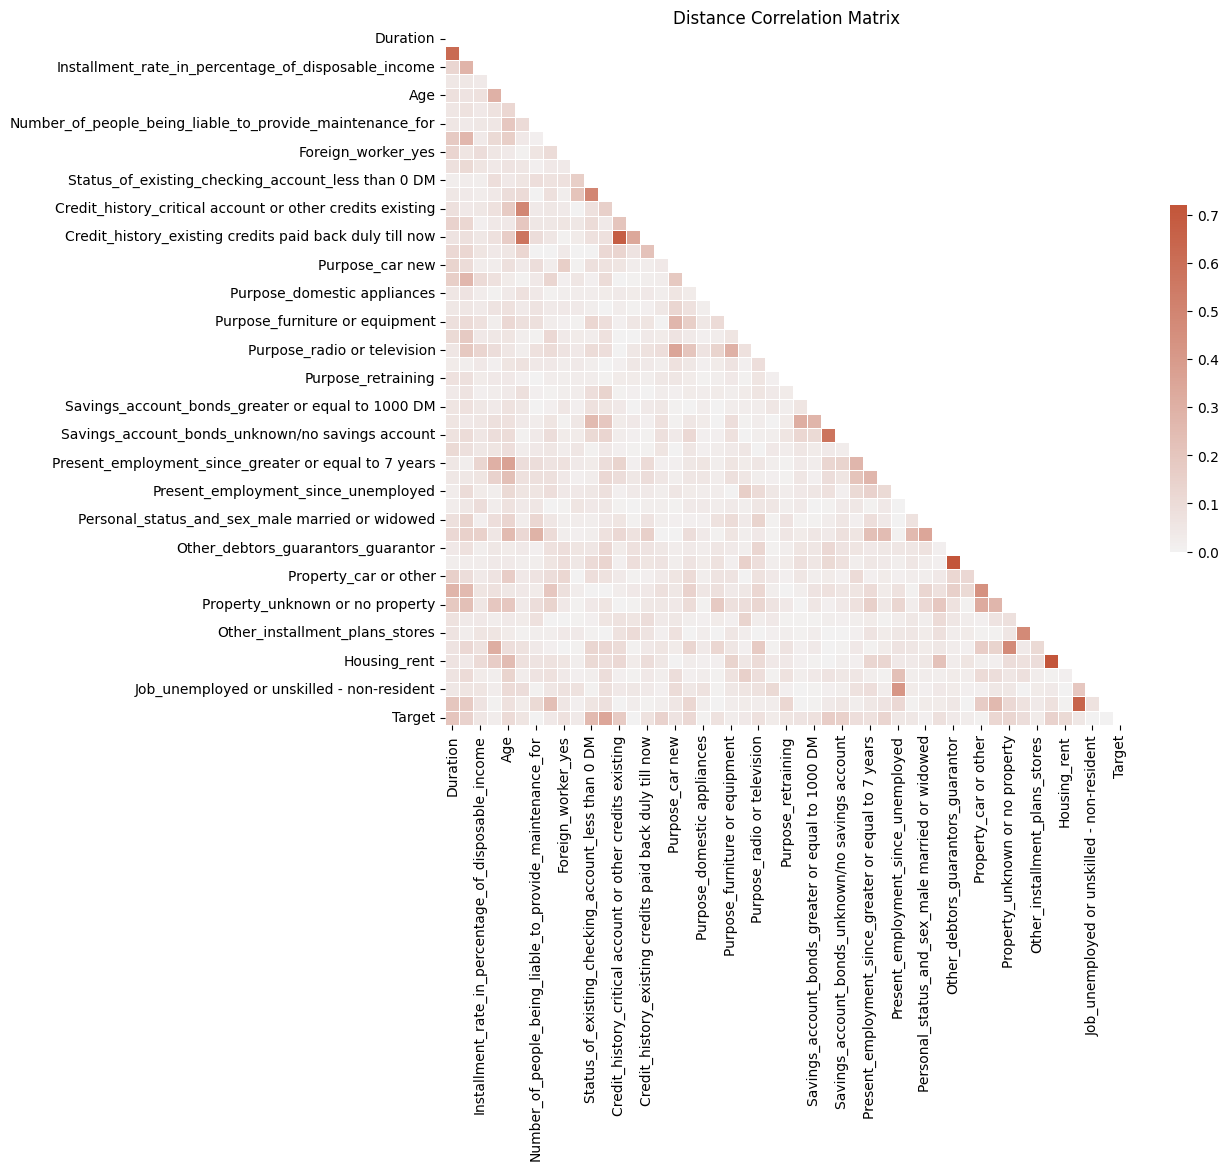

In [ ]:
german_dist_corr = calculate_distance_correlation_matrix(german_credit_train_encoded)

In [ ]:
german_dist_corr['Target'].sort_values(ascending=False)

Target                                                                                  1.000000
Status_of_existing_checking_account_no checking account                                 0.346321
Status_of_existing_checking_account_less than 0 DM                                      0.257063
Duration                                                                                0.207775
Credit_history_critical account or other credits existing                               0.177936
Savings_account_bonds_less than 100 DM                                                  0.164642
Savings_account_bonds_unknown/no savings account                                        0.148613
Credit_history_no credits taken or all credits paid back duly                           0.144767
Housing_own                                                                             0.142948
Credit_amount                                                                           0.142669
Present_employment_since_less than 1 year                                               0.133869
Property_unknown or no property                                                         0.125285
Property_real estate                                                                    0.121653
Purpose_car used                                                                        0.116122
Housing_rent                                                                            0.109587
Age                                                                                     0.105192
Other_installment_plans_none                                                            0.095538
Present_employment_since_from 4 to 7 years                                              0.088053
Personal_status_and_sex_male single                                                     0.079130
Present_employment_since_greater or equal to 7 years                                    0.078103
Savings_account_bonds_greater or equal to 1000 DM                                       0.075094
Purpose_radio or television                                                             0.074117
Foreign_worker_yes                                                                      0.073837
Purpose_education                                                                       0.071814
Credit_history_existing credits paid back duly till now                                 0.069956
Savings_account_bonds_from 500 to 1000 DM                                               0.067612
Purpose_car new                                                                         0.066709
Purpose_retraining                                                                      0.061507
Number_of_existing_credits_at_this_bank                                                 0.059480
Installment_rate_in_percentage_of_disposable_income                                     0.052113
Personal_status_and_sex_male divorced or separated                                      0.050063
Job_skilled employee or official                                                        0.047131
Present_employment_since_unemployed                                                     0.045466
Telephone_yes                                                                           0.039825
Purpose_others                                                                          0.039820
Other_debtors_guarantors_guarantor                                                      0.037547
Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments    0.036845
Purpose_repairs                                                                         0.030165
Other_installment_plans_stores                                                          0.029134
Other_debtors_guarantors_none                                                           0.026361
Present_residence_since                                                                 0.024086
Purpose_furniture or eq

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.05

german_zero_variance_columns = identify_zero_variance_columns(german_credit_train_encoded)

if DROP_WEAK_FEATURES:
  german_weak_features = identify_weak_associated_features(
      german_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  german_weak_features = []

remove_columns = set(german_zero_variance_columns + german_weak_features)
print(remove_columns)

german_credit_train = german_credit_train_encoded.drop(columns=remove_columns)
german_credit_test = german_credit_test_encoded.drop(columns=remove_columns)

Variance of each column:
Duration                                                                                1.485300e+02
Credit_amount                                                                           8.218001e+06
Installment_rate_in_percentage_of_disposable_income                                     1.251464e+00
Present_residence_since                                                                 1.207753e+00
Age                                                                                     1.301345e+02
Number_of_existing_credits_at_this_bank                                                 3.300360e-01
Number_of_people_being_liable_to_provide_maintenance_for                                1.320009e-01
Telephone_yes                                                                           2.434981e-01
Foreign_worker_yes                                                                      3.148310e-02
Status_of_existing_checking_account_greater or equal to 200 DM or 

In [ ]:
print('Original number of encoded features: ', len(german_credit_train_encoded.columns))
print('Number of features after pre-feature selection: ', len(german_credit_train.columns))

Original number of encoded features:  49
Number of features after pre-feature selection:  49


# **Imbalanced dataset**

In [ ]:
X_train = german_credit_train.drop('Target', axis=1)
y_train = german_credit_train['Target']

X_test = german_credit_test.drop('Target', axis=1)
y_test = german_credit_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0       560         0.7
1.0       240         0.3

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
german_imputation_values_dict = calculate_imputation_values_for_missing(
    german_credit_train
)
german_imputation_values_dict

{'Duration': 18.0,
 'Credit_amount': 2332.0,
 'Installment_rate_in_percentage_of_disposable_income': 3.0,
 'Present_residence_since': 3.0,
 'Age': 34.0,
 'Number_of_existing_credits_at_this_bank': 1.0,
 'Number_of_people_being_liable_to_provide_maintenance_for': 1.0,
 'Telephone_yes': 0.0,
 'Foreign_worker_yes': 1.0,
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments': 0.0,
 'Status_of_existing_checking_account_less than 0 DM': 0.0,
 'Status_of_existing_checking_account_no checking account': 0.0,
 'Credit_history_critical account or other credits existing': 0.0,
 'Credit_history_delay in paying off in the past': 0.0,
 'Credit_history_existing credits paid back duly till now': 1.0,
 'Credit_history_no credits taken or all credits paid back duly': 0.0,
 'Purpose_car new': 0.0,
 'Purpose_car used': 0.0,
 'Purpose_domestic appliances': 0.0,
 'Purpose_education': 0.0,
 'Purpose_furniture or equipment': 0.0,
 'Purpose_others': 0.0,
 'Purpose_radio or telev

In [ ]:
german_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
german_cat_vars

['Number_of_people_being_liable_to_provide_maintenance_for',
 'Telephone_yes',
 'Foreign_worker_yes',
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
 'Status_of_existing_checking_account_less than 0 DM',
 'Status_of_existing_checking_account_no checking account',
 'Credit_history_critical account or other credits existing',
 'Credit_history_delay in paying off in the past',
 'Credit_history_existing credits paid back duly till now',
 'Credit_history_no credits taken or all credits paid back duly',
 'Purpose_car new',
 'Purpose_car used',
 'Purpose_domestic appliances',
 'Purpose_education',
 'Purpose_furniture or equipment',
 'Purpose_others',
 'Purpose_radio or television',
 'Purpose_repairs',
 'Purpose_retraining',
 'Savings_account_bonds_from 500 to 1000 DM',
 'Savings_account_bonds_greater or equal to 1000 DM',
 'Savings_account_bonds_less than 100 DM',
 'Savings_account_bonds_unknown/no savings account',
 'Present_employment_since_from 4 t

In [ ]:
# Maximum number of original features to be imputed
NUM_FEAT = 20

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 0.005, 1]    # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
      'max_depth': [4],
      'min_samples_split': [0.1],
      'min_samples_leaf': [0.05]
  }

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:27:58.964686

Nested Cross-validation Results:
Individual scores: [0.64347826 0.5483871  0.56862745 0.66129032 0.62711864]
Average nested CV score: 0.610 (+/- 0.087)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.610

Train score: 0.621
Test score: 0.610
Train-test score difference: 0.011
2025-01-19 00:28:01.157668

Execution time: 0.04 minutes




```
Starting hyperparameter tuning at: 2025-01-14 22:45:58.846815

Nested Cross-validation Results:
Individual scores: [0.58585859 0.57142857 0.56862745 0.66129032 0.62711864]
Average nested CV score: 0.603 (+/- 0.072)

Fitting final model on entire dataset...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.610

Train score: 0.621
Test score: 0.610
Train-test score difference: 0.011
2025-01-14 22:46:31.854587

Execution time: 0.55 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.182138  0.023939
0                                            Duration    0.074325  0.002052
27             Savings_account_bonds_less than 100 DM    0.054433  0.014667
39                               Property_real estate    0.032548  0.009271
12  Credit_history_critical account or other credi...    0.024883  0.007207
7                                       Telephone_yes    0.019744  0.005282

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Savings_account_bonds']

--- NEW ITERATION ---
Removing feature:  Property_real e

In [ ]:
dt_orig_missing

['Status_of_existing_checking_account',
 'Duration',
 'Savings_account_bonds',
 'Property',
 'Credit_history',
 'Telephone',
 'Job',
 'Present_employment_since',
 'Personal_status_and_sex',
 'Other_debtors_guarantors',
 'Other_installment_plans',
 'Housing',
 'Purpose',
 'Present_residence_since',
 'Age',
 'Number_of_existing_credits_at_this_bank',
 'Number_of_people_being_liable_to_provide_maintenance_for',
 'Foreign_worker',
 'Installment_rate_in_percentage_of_disposable_income',
 'Credit_amount']

In [ ]:
len(dt_missing)

48

In [ ]:
dt_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  87   53  21      42.39   65.00        62.14      63.0     51.32   
1   50  59   81  10      38.17   83.33        42.14      54.5     52.36   
2   53  22  118   7      30.99   88.33        15.71      37.5     45.89   
3   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
4   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
5   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
6   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               63.57                 0   
1               62.74                 1   
2               52.02                 2   
3               50.00                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())


dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:28:18.869988

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
dt_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  87   53  21      42.39   65.00        62.14      63.0     51.32   
1   35  88   52  25      40.23   58.33        62.86      61.5     47.62   
2   33  83   57  27      36.67   55.00        59.29      58.0     44.00   
3   41  56   84  19      32.80   68.33        40.00      48.5     44.32   
4   44  45   95  16      31.65   73.33        32.14      44.5     44.22   
5   49  21  119  11      29.17   81.67        15.00      35.0     42.98   
6   49  22  118  11      29.34   81.67        15.71      35.5     43.17   
7   50  21  119  10      29.59   83.33        15.00      35.5     43.67   
8   55  20  120   5      31.43   91.67        14.29      37.5     46.81   
9   56  20  120   4      31.82   93.33        14.29      38.0     47.46   
10  56  21  119   4      32.00   93.33        15.00      38.5     47.66   
11  57  22  118   3      32.57   95.00        15.71      39.5     48.51   
12  57  27  113   3      33.53   95.00        19.29      42.0     49.57   
13  59   6  134   1      30.57   98.33         4.29      32.5     46.64   
14  59   8  132   1      30.89   98.33         5.71      33.5     47.01   
15  59   8  132   1      30.89   98.33         5.71      33.5     47.01   
16  59   8  132   1      30.89   98.33         5.71      33.5     47.01   
17  59   7  133   1      30.73   98.33         5.00      33.0     46.83   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               63.57                 0   
1               60.60                 1   
2               57.14                 2   
3               54.17                 3   
4               52.74                 4   
5               48.33                 5   
6               48.69                 6   
7               49.17                 7   
8               52.98                 8   
9               53.81                 9   
10              54.17                10   
11              55.36                11   
12              57.14                12   
13              51.31                13   
14              52.02                14   
15              52.02                15   
16              52.02                16   
17              51.67                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 2],
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 1]
  }
else:
  # best model
  rf_param_grid = {
      'n_estimators': [300],
      'max_features': ['sqrt'],
      'min_samples_split': [0.01],
      'min_samples_leaf': [0.01],
      'max_depth': [3]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(rf_classifier, rf_param_grid, 5, 5, 'f1', X_train, y_train)

Starting hyperparameter tuning at: 2025-01-19 00:31:04.062973

Nested Cross-validation Results:
Individual scores: [0.71544715 0.56198347 0.51851852 0.65454545 0.6446281 ]
Average nested CV score: 0.619 (+/- 0.140)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.619

Train score: 0.653
Test score: 0.619
Train-test score difference: 0.034
2025-01-19 00:31:09.186957

Execution time: 0.09 minutes



```
Starting hyperparameter tuning at: 2025-01-14 22:51:58.303263

Nested Cross-validation Results:
Individual scores: [0.73043478 0.5982906  0.50943396 0.61682243 0.57657658]
Average nested CV score: 0.606 (+/- 0.144)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.619

Train score: 0.653
Test score: 0.619
Train-test score difference: 0.034
2025-01-14 23:44:28.803554

Execution time: 52.51 minutes
```





In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
11  Status_of_existing_checking_account_no checkin...  9.197904e-02  0.022692
0                                            Duration  1.592968e-02  0.004663
27             Savings_account_bonds_less than 100 DM  9.726128e-03  0.005921
12  Credit_history_critical account or other credi...  8.276004e-03  0.006714
17                                   Purpose_car used  4.695547e-03  0.002871
44                                       Housing_rent  3.952831e-03  0.003280
1                                       Credit_amount  3.951660e-03  0.005583
39                               Property_real estate  3.569821e-03  0.005978
28   Savings_account_bonds_unknown/no savings account  2.980461e-03  0.002266
45                   Job_skilled employee or official  2.917342e-03  0.004334
30  Present_employment_since_greater or equal to 7...  2.791624e-03  0.003260
10  Status_of_existing_checking_account_less than ...  2.617618e-03  0.003920
2   Installment_rate_in_percentage_of_disposable_i...  2.431357e-03  0.002402
35                Personal_status_and_sex_male single  2.216910e-03  0.002968
13     Credit_history_delay in paying off in the past  2.190707e-03  0.000000
26  Savings_account_bonds_greater or equal to 1000 DM  1.823770e-03  0.001870
36                 Other_debtors_guarantors_guarantor  1.821860e-03  0.000912
25          Savings_account_bonds_from 500 to 1000 DM  1.577822e-03  0.002633
14  Credit_history_existing credits paid back duly...  1.340241e-03  0.001349
29         Present_employment_since_from 4 to 7 years  1.276723e-03  0.002623
5             Number_of_existing_credits_at_this_bank  1.031278e-03  0.003099
8                                  Foreign_worker_yes  9.434166e-04  0.002429
31          Present_employment_since_less than 1 year  6.811693e-04  0.001705
33  Personal_status_and_sex_male divorced or separ...  4.173521e-04  0.001524
37                      Other_debtors_guarantors_none -7.476750e-07  0.000695
7                                       Telephone_yes -1.989188e-04  0.000858
20                     Purpose_furniture or equipment -2.201903e-04  0.000440
34    Personal_status_and_sex_male married or widowed -2.421308e-04  0.001793
16                                    Purpose_car new -2.797787e-04  0.001960
15  Credit_history_no credits taken or all credits... -4.615772e-04  0.001681
19                                  Purpose_education -6.994993e-04  0.000925
47                           Job_unskilled - resident -8.807612e-04  0.000440
6   Number_of_people_being_liable_to_provide_maint... -9.193491e-04  0.001126
38                              Property_car or other -9.211813e-04  0.001308
9   Status_of_existing_checking_account_greater or... -9.800179e-04  0.000438
42                     Other_installment_plans_stores -1.360137e-03  0.001328
4                                                 Age -1.427932e-03  0.002451
32                Present_employment_since_unemployed -1.561785e-03  0.001154
41                       Other_installment_plans_none -1.964127e-03  0.002099
3                             Present_residence_since -2.151047e-03  0.001597
22                        Purpose_radio or television -3.145996e-03  0.001808
40                    Property_unknown or no property -3.859410e-03  0.003485
43                                        Housing_own -6.159981e-03  0.004576

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Savings_account_bonds']

--- NEW ITERATION ---
Removing feature:  Credit_history_

In [ ]:
rf_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  97   43  21      47.56   65.00        69.29      68.0     54.93   
1   47  95   45  13      51.09   78.33        67.86      71.0     61.84   
2   47  82   58  13      44.76   78.33        58.57      64.5     56.97   
3   52  59   81   8      39.10   86.67        42.14      55.5     53.89   
4   55  27  113   5      32.74   91.67        19.29      41.0     48.25   
5   56  23  117   4      32.37   93.33        16.43      39.5     48.07   
6   55  26  114   5      32.54   91.67        18.57      40.5     48.03   
7   54  29  111   6      32.73   90.00        20.71      41.5     48.00   
8   60   8  132   0      31.25  100.00         5.71      34.0     47.62   
9   60  11  129   0      31.75  100.00         7.86      35.5     48.19   
10  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
11  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
12  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
13  60   2  138   0      30.30  100.00         1.43      31.0     46.51   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.14                 0   
1               73.10                 1   
2               68.45                 2   
3               64.40                 3   
4               55.48                 4   
5               54.88                 5   
6               55.12                 6   
7               55.36                 7   
8               52.86                 8   
9               53.93                 9   
10              51.07                10   
11              51.07                11   
12              51.07                12   
13              50.71                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:31:11.886846

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
rf_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  97   43  21      47.56   65.00        69.29      68.0     54.93   
1   37  87   53  23      41.11   61.67        62.14      62.0     49.33   
2   37  87   53  23      41.11   61.67        62.14      62.0     49.33   
3   45  54   86  15      34.35   75.00        38.57      49.5     47.12   
4   53  33  107   7      33.12   88.33        23.57      43.0     48.18   
5   46  30  110  14      29.49   76.67        21.43      38.0     42.59   
6   45  30  110  15      29.03   75.00        21.43      37.5     41.86   
7   45  29  111  15      28.85   75.00        20.71      37.0     41.67   
8   45  31  109  15      29.22   75.00        22.14      38.0     42.06   
9   43  35  105  17      29.05   71.67        25.00      39.0     41.35   
10  45  39  101  15      30.82   75.00        27.86      42.0     43.69   
11  41  43   97  19      29.71   68.33        30.71      42.0     41.41   
12  59   8  132   1      30.89   98.33         5.71      33.5     47.01   
13  58  10  130   2      30.85   96.67         7.14      34.0     46.77   
14  57  11  129   3      30.65   95.00         7.86      34.0     46.34   
15  57   9  131   3      30.32   95.00         6.43      33.0     45.97   
16  59   0  140   1      29.65   98.33         0.00      29.5     45.56   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.14                 0   
1               61.90                 1   
2               61.90                 2   
3               56.79                 3   
4               55.95                 4   
5               49.05                 5   
6               48.21                 6   
7               47.86                 7   
8               48.57                 8   
9               48.33                 9   
10              51.43                10   
11              49.52                11   
12              52.02                12   
13              51.90                13   
14              51.43                14   
15              50.71                15   
16              49.17                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

2.3333333333333335

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [40, 8, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
    'n_estimators': [100],
    'max_depth': [None],
    'min_child_samples': [1],
    'min_split_gain': [0.5],
    'reg_lambda': [10.0]
}

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:33:59.555450

Nested Cross-validation Results:
Individual scores: [0.71698113 0.60869565 0.58       0.58585859 0.60869565]
Average nested CV score: 0.620 (+/- 0.100)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': None, 'min_child_samples': 1, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.620

Train score: 0.868
Test score: 0.620
Train-test score difference: 0.248
2025-01-19 00:34:00.921672

Execution time: 0.02 minutes


```
Starting hyperparameter tuning at: 2025-01-14 23:44:28.872265

Nested Cross-validation Results:
Individual scores: [0.7047619  0.60504202 0.53333333 0.56       0.5982906 ]
Average nested CV score: 0.600 (+/- 0.117)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': None, 'min_child_samples': 1, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.620

Train score: 0.868
Test score: 0.620
Train-test score difference: 0.248
2025-01-14 23:48:52.942853

Execution time: 4.40 minutes
```





In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.178142  0.017007
1                                       Credit_amount    0.142273  0.010185
0                                            Duration    0.139868  0.011823
4                                                 Age    0.080778  0.007953
17                                   Purpose_car used    0.039405  0.006300
12  Credit_history_critical account or other credi...    0.035692  0.009532
29         Present_employment_since_from 4 to 7 years    0.025921  0.005680
3                             Present_residence_since    0.024747  0.004938
28   Savings_account_bonds_unknown/no savings account    0.022433  0.004021
10  Status_of_existing_checking_account_less than ...    0.021620  0.005289
41                       Other_installment_plans_none    0.019485  0.003985
9   Status_of_existing_checking_account_greater or...    0.015682  0.003383
31          Present_employment_since_less than 1 year    0.013589  0.002614
36                 Other_debtors_guarantors_guarantor    0.013472  0.003182
39                               Property_real estate    0.012405  0.002291
2   Installment_rate_in_percentage_of_disposable_i...    0.010574  0.000723
43                                        Housing_own    0.010224  0.005710
27             Savings_account_bonds_less than 100 DM    0.009278  0.002613
26  Savings_account_bonds_greater or equal to 1000 DM    0.008210  0.002317
16                                    Purpose_car new    0.007453  0.002334
8                                  Foreign_worker_yes    0.004546  0.001793
30  Present_employment_since_greater or equal to 7...    0.003466  0.002232
40                    Property_unknown or no property    0.003153  0.002377
35                Personal_status_and_sex_male single    0.003129  0.001579
45                   Job_skilled employee or official    0.002927  0.002788
24                                 Purpose_retraining    0.002285  0.000797
25          Savings_account_bonds_from 500 to 1000 DM    0.002285  0.000797
5             Number_of_existing_credits_at_this_bank    0.001942  0.001211
14  Credit_history_existing credits paid back duly...    0.001719  0.000859
22                        Purpose_radio or television    0.001310  0.003350
15  Credit_history_no credits taken or all credits...    0.001204  0.001787
19                                  Purpose_education    0.000552  0.000902
13     Credit_history_delay in paying off in the past    0.000430  0.000859
33  Personal_status_and_sex_male divorced or separ...    0.000327  0.000653
34    Personal_status_and_sex_male married or widowed   -0.000984  0.000803
44                                       Housing_rent   -0.002138  0.002742

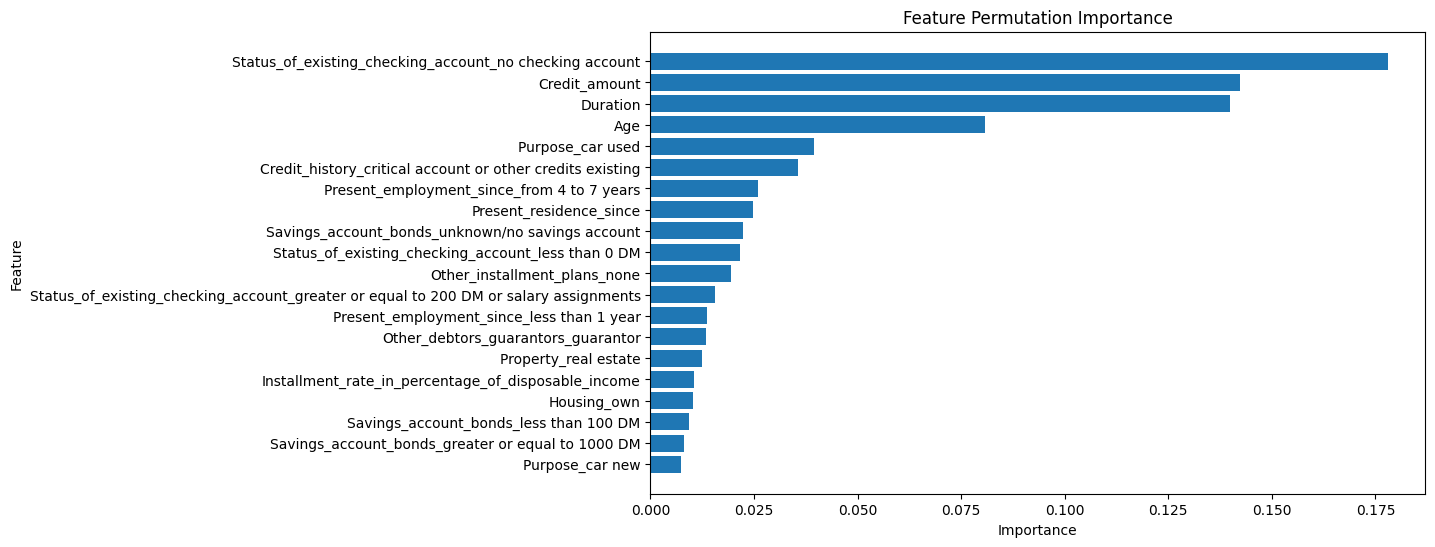

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount', 'Duration']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount', 'Duration', 'Age']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic applianc

In [ ]:
gbt_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41  108   32  19      56.16   68.33        77.14      74.5     61.65   
1   45   91   49  15      47.87   75.00        65.00      68.0     58.44   
2   35   97   43  25      44.87   58.33        69.29      66.0     50.72   
3   35   92   48  25      42.17   58.33        65.71      63.5     48.95   
4   34   92   48  26      41.46   56.67        65.71      63.0     47.89   
5   37   93   47  23      44.05   61.67        66.43      65.0     51.39   
6   40   81   59  20      40.40   66.67        57.86      60.5     50.31   
7   48   62   78  12      38.10   80.00        44.29      55.0     51.61   
8   48   54   86  12      35.82   80.00        38.57      51.0     49.48   
9   59    9  131   1      31.05   98.33         6.43      34.0     47.20   
10  59    9  131   1      31.05   98.33         6.43      34.0     47.20   
11  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               72.74                 0   
1               70.00                 1   
2               63.81                 2   
3               62.02                 3   
4               61.19                 4   
5               64.05                 5   
6               62.26                 6   
7               62.14                 7   
8               59.29                 8   
9               52.38                 9   
10              52.38                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:34:01.837730

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
gbt_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41  108   32  19      56.16   68.33        77.14      74.5     61.65   
1   37  101   39  23      48.68   61.67        72.14      69.0     54.41   
2   34  105   35  26      49.28   56.67        75.00      69.5     52.71   
3   33   92   48  27      40.74   55.00        65.71      62.5     46.81   
4   33   95   45  27      42.31   55.00        67.86      64.0     47.83   
5   29   92   48  31      37.66   48.33        65.71      60.5     42.34   
6   33   82   58  27      36.26   55.00        58.57      57.5     43.71   
7   35   89   51  25      40.70   58.33        63.57      62.0     47.95   
8   40   65   75  20      34.78   66.67        46.43      52.5     45.71   
9   41   31  109  19      27.33   68.33        22.14      36.0     39.05   
10  39   31  109  21      26.35   65.00        22.14      35.0     37.50   
11  39   30  110  21      26.17   65.00        21.43      34.5     37.32   
12  39   38  102  21      27.66   65.00        27.14      38.5     38.81   
13  40   42   98  20      28.99   66.67        30.00      41.0     40.40   
14  36   47   93  24      27.91   60.00        33.57      41.5     38.10   
15  36   47   93  24      27.91   60.00        33.57      41.5     38.10   
16  49   21  119  11      29.17   81.67        15.00      35.0     42.98   
17  56   11  129   4      30.27   93.33         7.86      33.5     45.71   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               72.74                 0   
1               66.90                 1   
2               65.83                 2   
3               60.36                 3   
4               61.43                 4   
5               57.02                 5   
6               56.79                 6   
7               60.95                 7   
8               56.55                 8   
9               45.24                 9   
10              43.57                10   
11              43.21                11   
12              46.07                12   
13              48.33                13   
14              46.79                14   
15              46.79                15   
16              48.33                16   
17              50.60                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # Best model
  xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[10.0],
    'gamma': [0.0],
    'colsample_bytree':[0.5]
}

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:36:49.109495

Nested Cross-validation Results:
Individual scores: [0.72566372 0.5862069  0.55045872 0.56565657 0.66101695]
Average nested CV score: 0.618 (+/- 0.132)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.618

Train score: 0.753
Test score: 0.618
Train-test score difference: 0.135
2025-01-19 00:36:52.744868

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-14 17:14:33.558392

Nested Cross-validation Results:
Individual scores: [0.67256637 0.57142857 0.51376147 0.57142857 0.61538462]
Average nested CV score: 0.589 (+/- 0.106)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.618

Train score: 0.753
Test score: 0.618
Train-test score difference: 0.135
2025-01-14 17:41:04.025720

Execution time: 26.51 minutes
```




In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.075763  0.013337
0                                            Duration    0.062129  0.013221
1                                       Credit_amount    0.049645  0.013330
17                                   Purpose_car used    0.032070  0.010057
3                             Present_residence_since    0.018228  0.006075
4                                                 Age    0.016812  0.005444
29         Present_employment_since_from 4 to 7 years    0.013840  0.004133
12  Credit_history_critical account or other credi...    0.012685  0.010244
41                       Other_installment_plans_none    0.007556  0.002504
35                Personal_status_and_sex_male single    0.005709  0.002044
16                                    Purpose_car new    0.004902  0.000954
2   Installment_rate_in_percentage_of_disposable_i...    0.004793  0.005753
15  Credit_history_no credits taken or all credits...    0.004018  0.002674
27             Savings_account_bonds_less than 100 DM    0.003958  0.003509
36                 Other_debtors_guarantors_guarantor    0.003754  0.001822
28   Savings_account_bonds_unknown/no savings account    0.003151  0.007841
8                                  Foreign_worker_yes    0.002857  0.002095
19                                  Purpose_education    0.002135  0.001590
20                     Purpose_furniture or equipment    0.002074  0.001151
34    Personal_status_and_sex_male married or widowed    0.002060  0.000629
43                                        Housing_own    0.001695  0.007059
32                Present_employment_since_unemployed    0.001289  0.000000
30  Present_employment_since_greater or equal to 7...    0.000907  0.002308
44                                       Housing_rent    0.000655  0.004198
6   Number_of_people_being_liable_to_provide_maint...    0.000640  0.001665
47                           Job_unskilled - resident    0.000595  0.001118
9   Status_of_existing_checking_account_greater or...   -0.000454  0.002638
39                               Property_real estate   -0.000474  0.006373
7                                       Telephone_yes   -0.000585  0.001248
42                     Other_installment_plans_stores   -0.001294  0.000000
45                   Job_skilled employee or official   -0.001427  0.000933
33  Personal_status_and_sex_male divorced or separ...   -0.001489  0.001781
13     Credit_history_delay in paying off in the past   -0.002460  0.001015
10  Status_of_existing_checking_account_less than ...   -0.003838  0.006017
40                    Property_unknown or no property   -0.006111  0.002594
31          Present_employment_since_less than 1 year   -0.007596  0.003546

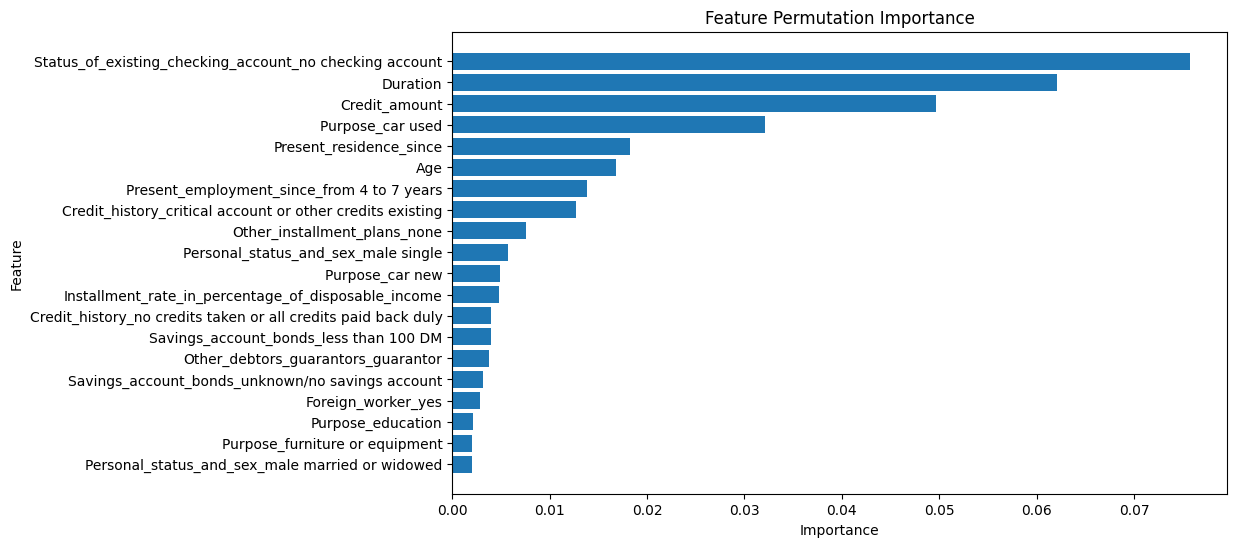

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio or television', 'Purpose_repairs', 'Purpose_retraining']
Original

In [ ]:
xgb_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41  109   31  19      56.94   68.33        77.86      75.0     62.12   
1   43   95   45  17      48.86   71.67        67.86      69.0     58.11   
2   43   88   52  17      45.26   71.67        62.86      65.5     55.48   
3   34  104   36  26      48.57   56.67        74.29      69.0     52.31   
4   38  105   35  22      52.05   63.33        75.00      71.5     57.14   
5   39   93   47  21      45.35   65.00        66.43      66.0     53.42   
6   36   92   48  24      42.86   60.00        65.71      64.0     50.00   
7   40   87   53  20      43.01   66.67        62.14      63.5     52.29   
8   47   57   83  13      36.15   78.33        40.71      52.0     49.47   
9   47   60   80  13      37.01   78.33        42.86      53.5     50.27   
10  42   65   75  18      35.90   70.00        46.43      53.5     47.46   
11  48   49   91  12      34.53   80.00        35.00      48.5     48.24   
12  55   23  117   5      31.98   91.67        16.43      39.0     47.41   
13  56   16  124   4      31.11   93.33        11.43      36.0     46.67   
14  57    8  132   3      30.16   95.00         5.71      32.5     45.78   
15  56    9  131   4      29.95   93.33         6.43      32.5     45.34   
16  56   10  130   4      30.11   93.33         7.14      33.0     45.53   
17  54   16  124   6      30.34   90.00        11.43      35.0     45.38   
18  54   16  124   6      30.34   90.00        11.43      35.0     45.38   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.10                 0   
1               69.76                 1   
2               67.26                 2   
3               65.48                 3   
4               69.17                 4   
5               65.71                 5   
6               62.86                 6   
7               64.40                 7   
8               59.52                 8   
9               60.60                 9   
10              58.21                10   
11              57.50                11   
12              54.05                12   
13              52.38                13   
14              50.36                14   
15              49.88                15   
16              50.24                16   
17              50.71                17   
18              50.71                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:36:54.545190

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
xgb_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41  109   31  19      56.94   68.33        77.86      75.0     62.12   
1   40   99   41  20      49.38   66.67        70.71      69.5     56.74   
2   37   95   45  23      45.12   61.67        67.86      66.0     52.11   
3   31   99   41  29      43.06   51.67        70.71      65.0     46.97   
4   27   93   47  33      36.49   45.00        66.43      60.0     40.30   
5   28   94   46  32      37.84   46.67        67.14      61.0     41.79   
6   28   86   54  32      34.15   46.67        61.43      57.0     39.44   
7   33   94   46  27      41.77   55.00        67.14      63.5     47.48   
8   39   78   62  21      38.61   65.00        55.71      58.5     48.45   
9   35   77   63  25      35.71   58.33        55.00      56.0     44.30   
10  34   81   59  26      36.56   56.67        57.86      57.5     44.44   
11  32   81   59  28      35.16   53.33        57.86      56.5     42.38   
12  42   44   96  18      30.43   70.00        31.43      43.0     42.42   
13  42   44   96  18      30.43   70.00        31.43      43.0     42.42   
14  43   38  102  17      29.66   71.67        27.14      40.5     41.95   
15  36   42   98  24      26.87   60.00        30.00      39.0     37.11   
16  38   44   96  22      28.36   63.33        31.43      41.0     39.18   
17  42   47   93  18      31.11   70.00        33.57      44.5     43.08   
18  54   16  124   6      30.34   90.00        11.43      35.0     45.38   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.10                 0   
1               68.69                 1   
2               64.76                 2   
3               61.19                 3   
4               55.71                 4   
5               56.90                 5   
6               54.05                 6   
7               61.07                 7   
8               60.36                 8   
9               56.67                 9   
10              57.26                10   
11              55.60                11   
12              50.71                12   
13              50.71                13   
14              49.40                14   
15              45.00                15   
16              47.38                16   
17              51.79                17   
18              50.71                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.05, 0.01, 2],
      'min_samples_leaf': [0.05, 0.01, 1]
  }
else:
  # best model
  et_param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'max_features':[1.0],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01],
}

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:39:43.664941

Nested Cross-validation Results:
Individual scores: [0.66666667 0.61666667 0.53097345 0.62135922 0.69026549]
Average nested CV score: 0.625 (+/- 0.109)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.625

Train score: 0.798
Test score: 0.625
Train-test score difference: 0.172
2025-01-19 00:39:49.452883

Execution time: 0.10 minutes


```
Starting hyperparameter tuning at: 2025-01-14 23:48:55.063375

Nested Cross-validation Results:
Individual scores: [0.66071429 0.55737705 0.54545455 0.60377358 0.6031746 ]
Average nested CV score: 0.594 (+/- 0.082)

Fitting final model on entire dataset...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.625

Train score: 0.798
Test score: 0.625
Train-test score difference: 0.172
2025-01-15 00:27:56.451632

Execution time: 39.02 minutes
```




In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.215928  0.021864
0                                            Duration    0.098162  0.009535
12  Credit_history_critical account or other credi...    0.063238  0.014575
28   Savings_account_bonds_unknown/no savings account    0.049076  0.013995
39                               Property_real estate    0.041944  0.003610
27             Savings_account_bonds_less than 100 DM    0.036798  0.005774
9   Status_of_existing_checking_account_greater or...    0.029262  0.007115
10  Status_of_existing_checking_account_less than ...    0.022724  0.002876
35                Personal_status_and_sex_male single    0.020545  0.004101
41                       Other_installment_plans_none    0.018933  0.009239
36                 Other_debtors_guarantors_guarantor    0.016936  0.002272
7                                       Telephone_yes    0.015460  0.007235
17                                   Purpose_car used    0.015391  0.002771
1                                       Credit_amount    0.015199  0.002128
30  Present_employment_since_greater or equal to 7...    0.013087  0.002499
38                              Property_car or other    0.010954  0.003184
29         Present_employment_since_from 4 to 7 years    0.010916  0.001742
5             Number_of_existing_credits_at_this_bank    0.010408  0.004362
14  Credit_history_existing credits paid back duly...    0.007769  0.002669
22                        Purpose_radio or television    0.004215  0.001797
16                                    Purpose_car new    0.003724  0.001587
45                   Job_skilled employee or official    0.003716  0.003028
2   Installment_rate_in_percentage_of_disposable_i...    0.003531  0.003212
31          Present_employment_since_less than 1 year    0.002791  0.000880
37                      Other_debtors_guarantors_none    0.002188  0.002374
40                    Property_unknown or no property    0.001398  0.000883
34    Personal_status_and_sex_male married or widowed    0.000839  0.000685
3                             Present_residence_since    0.000193  0.002918
44                                       Housing_rent   -0.000002  0.001253
47                           Job_unskilled - resident   -0.000164  0.002036
13     Credit_history_delay in paying off in the past   -0.000281  0.000561
4                                                 Age   -0.000325  0.002045
26  Savings_account_bonds_greater or equal to 1000 DM   -0.000842  0.000688
43                                        Housing_own   -0.001685  0.000563

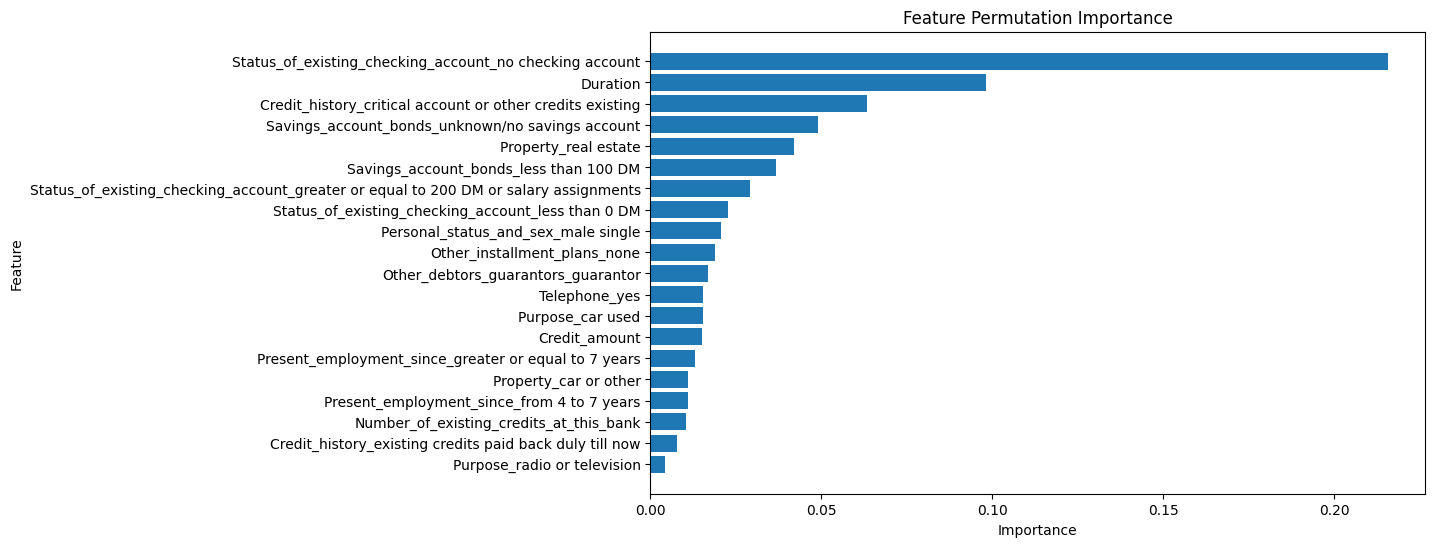

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Credit_history_critical account or other credits existing
Removing related features:  ['Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Credit_history_existing credits paid back duly till now', 'Credit_history_no credits taken or all credits paid back duly']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Credit_history']

-

In [ ]:
et_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   46  95   45  14      50.55   76.67        67.86      70.5     60.93   
1   47  75   65  13      41.96   78.33        53.57      61.0     54.65   
2   47  66   74  13      38.84   78.33        47.14      56.5     51.93   
3   48  61   79  12      37.80   80.00        43.57      54.5     51.34   
4   58  13  127   2      31.35   96.67         9.29      35.5     47.35   
5   58  14  126   2      31.52   96.67        10.00      36.0     47.54   
6   56  15  125   4      30.94   93.33        10.71      35.5     46.47   
7   56  15  125   4      30.94   93.33        10.71      35.5     46.47   
8   57   4  136   3      29.53   95.00         2.86      30.5     45.06   
9   59   4  136   1      30.26   98.33         2.86      31.5     46.27   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               72.26                 0   
1               65.95                 1   
2               62.74                 2   
3               61.79                 3   
4               52.98                 4   
5               53.33                 5   
6               52.02                 6   
7               52.02                 7   
8               48.93                 8   
9               50.60                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:39:53.520828

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
et_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   46  95   45  14      50.55   76.67        67.86      70.5     60.93   
1   40  91   49  20      44.94   66.67        65.00      65.5     53.69   
2   39  87   53  21      42.39   65.00        62.14      63.0     51.32   
3   45  70   70  15      39.13   75.00        50.00      57.5     51.43   
4   50  40  100  10      33.33   83.33        28.57      45.0     47.62   
5   51  33  107   9      32.28   85.00        23.57      42.0     46.79   
6   51  32  108   9      32.08   85.00        22.86      41.5     46.58   
7   51  36  104   9      32.90   85.00        25.71      43.5     47.44   
8   52  30  110   8      32.10   86.67        21.43      41.0     46.85   
9   51  29  111   9      31.48   85.00        20.71      40.0     45.95   
10  54  22  118   6      31.40   90.00        15.71      38.0     46.55   
11  55  16  124   5      30.73   91.67        11.43      35.5     46.03   
12  52  17  123   8      29.71   86.67        12.14      34.5     44.26   
13  52  17  123   8      29.71   86.67        12.14      34.5     44.26   
14  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
15  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
16  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               72.26                 0   
1               65.83                 1   
2               63.57                 2   
3               62.50                 3   
4               55.95                 4   
5               54.29                 5   
6               53.93                 6   
7               55.36                 7   
8               54.05                 8   
9               52.86                 9   
10              52.86                10   
11              51.55                11   
12              49.40                12   
13              49.40                13   
14              50.24                14   
15              51.07                15   
16              51.07                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, german_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = german_scaler)

In [ ]:
german_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
german_imputation_scaled_values_dict

{'Duration': 0.20588235294117646,
 'Credit_amount': 0.11329072074057747,
 'Installment_rate_in_percentage_of_disposable_income': 0.6666666666666667,
 'Present_residence_since': 0.6666666666666667,
 'Age': 0.26785714285714285,
 'Number_of_existing_credits_at_this_bank': 0.0,
 'Number_of_people_being_liable_to_provide_maintenance_for': 0.0,
 'Telephone_yes': 0.0,
 'Foreign_worker_yes': 1.0,
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments': 0.0,
 'Status_of_existing_checking_account_less than 0 DM': 0.0,
 'Status_of_existing_checking_account_no checking account': 0.0,
 'Credit_history_critical account or other credits existing': 0.0,
 'Credit_history_delay in paying off in the past': 0.0,
 'Credit_history_existing credits paid back duly till now': 1.0,
 'Credit_history_no credits taken or all credits paid back duly': 0.0,
 'Purpose_car new': 0.0,
 'Purpose_car used': 0.0,
 'Purpose_domestic appliances': 0.0,
 'Purpose_education': 0.0,
 'Purpose_furni

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.1, 1, 2, 3, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm_param_grid = {
    'C': [0.1],
    'kernel': ['linear'],
    'gamma': ['scale'],
    'degree': [2]
}

svm_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 5, 5, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:42:39.205796

Nested Cross-validation Results:
Individual scores: [0.64615385 0.56692913 0.59130435 0.60714286 0.58914729]
Average nested CV score: 0.600 (+/- 0.053)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.600

Train score: 0.637
Test score: 0.600
Train-test score difference: 0.037
2025-01-19 00:42:39.437049

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-14 18:21:27.899730

Nested Cross-validation Results:
Individual scores: [0.62295082 0.53030303 0.59130435 0.60714286 0.6       ]
Average nested CV score: 0.590 (+/- 0.064)

Fitting final model on entire dataset...
Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.600

Train score: 0.637
Test score: 0.600
Train-test score difference: 0.037
2025-01-14 18:24:13.103186

Execution time: 2.75 minutes
```




In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1")
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.097553  0.014883
10  Status_of_existing_checking_account_less than ...    0.006166  0.005824
28   Savings_account_bonds_unknown/no savings account    0.005017  0.003231
36                 Other_debtors_guarantors_guarantor    0.005002  0.004837
29         Present_employment_since_from 4 to 7 years    0.004790  0.005384
17                                   Purpose_car used    0.004027  0.003830
47                           Job_unskilled - resident    0.003843  0.002957
1                                       Credit_amount    0.003736  0.003854
40                    Property_unknown or no property    0.003362  0.001616
8                                  Foreign_worker_yes    0.003360  0.002968
0                                            Duration    0.003269  0.005471
12  Credit_history_critical account or other credi...    0.003181  0.009302
33  Personal_status_and_sex_male divorced or separ...    0.002980  0.001969
38                              Property_car or other    0.001489  0.001963
21                                     Purpose_others    0.001038  0.000000
23                                    Purpose_repairs    0.001036  0.001133
43                                        Housing_own    0.000789  0.001735
26  Savings_account_bonds_greater or equal to 1000 DM    0.000664  0.002947
9   Status_of_existing_checking_account_greater or...    0.000546  0.002704
15  Credit_history_no credits taken or all credits...    0.000541  0.001441
46         Job_unemployed or unskilled - non-resident    0.000207  0.000778
30  Present_employment_since_greater or equal to 7...    0.000080  0.003106
20                     Purpose_furniture or equipment    0.000048  0.000768
44                                       Housing_rent   -0.000040  0.001375
4                                                 Age   -0.000173  0.003763
13     Credit_history_delay in paying off in the past   -0.000417  0.000832
32                Present_employment_since_unemployed   -0.000455  0.000909
19                                  Purpose_education   -0.000456  0.001087
25          Savings_account_bonds_from 500 to 1000 DM   -0.000592  0.002487
24                                 Purpose_retraining   -0.000834  0.000780
34    Personal_status_and_sex_male married or widowed   -0.001041  0.000000
14  Credit_history_existing credits paid back duly...   -0.001212  0.001452
6   Number_of_people_being_liable_to_provide_maint...   -0.001820  0.002024
42                     Other_installment_plans_stores   -0.002232  0.002929
7                                       Telephone_yes   -0.002343  0.003466
41                       Other_installment_plans_none   -0.002432  0.001907
39                               Property_real estate   -0.002630  0.002602
37                      Other_debtors_guarantors_none   -0.003050  0.004879
22                        Purpose_radio or television   -0.003317  0.000000
2   Installment_rate_in_percentage_of_disposable_i...   -0.003923  0.003119
31          Present_employment_since_less than 1 year   -0.004222  0.001191
3                             Present_residence_since   -0.004597  0.002877
27             Savings_account_bonds_less than 100 DM   -0.005051  0.004033
16                                    Purpose_car new   -0.005711  0.005477
45                   Job_skilled employee or official   -0.005984  0.005016
35                Personal_status_and_sex_male single   -0.008665  0.006156

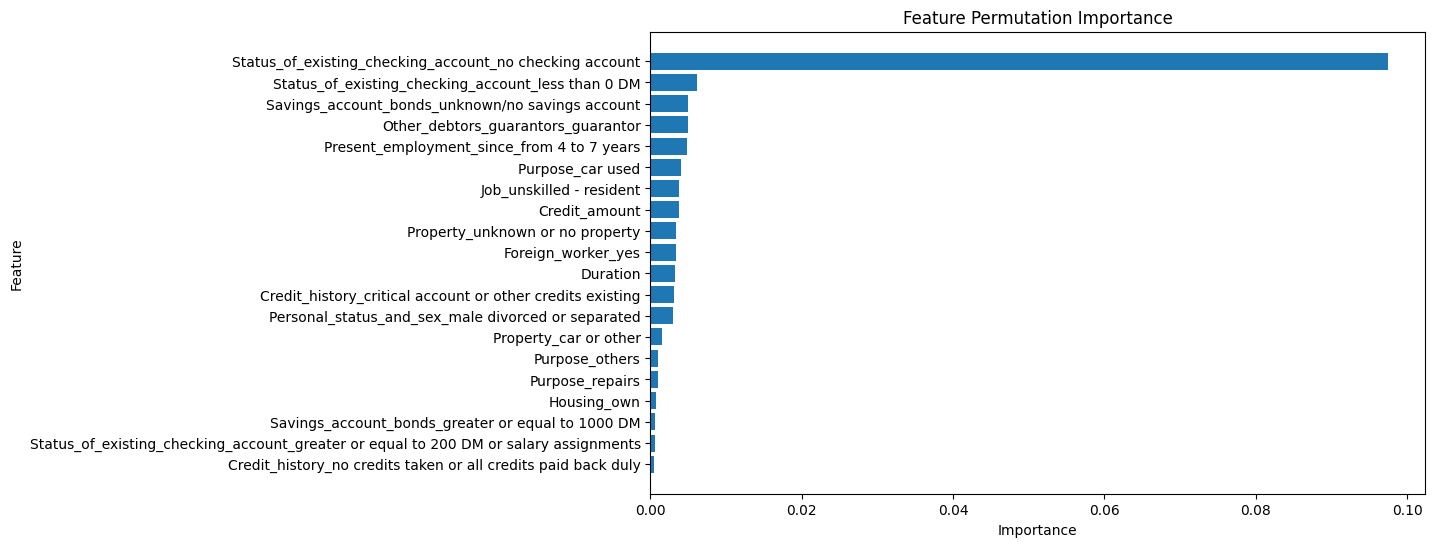

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_unknown/no savings account
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Savings_account_bonds']

--- NEW ITERATION ---
Removing feature:  Other_debtors_guarantors_guarantor
Removing related features:  ['Other_debtors_guarantors_guarantor', 'Other_debtors_guarantors_

In [ ]:
svm_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  97   43  20      48.19   66.67        69.29      68.5     55.94   
1   46  81   59  14      43.81   76.67        57.86      63.5     55.76   
2   52  65   75   8      40.94   86.67        46.43      58.5     55.61   
3   52  65   75   8      40.94   86.67        46.43      58.5     55.61   
4   56  54   86   4      39.44   93.33        38.57      55.0     55.45   
5   55  43   97   5      36.18   91.67        30.71      49.0     51.89   
6   54  49   91   6      37.24   90.00        35.00      51.5     52.68   
7   53  49   91   7      36.81   88.33        35.00      51.0     51.96   
8   54  43   97   6      35.76   90.00        30.71      48.5     51.18   
9   55  36  104   5      34.59   91.67        25.71      45.5     50.23   
10  56  37  103   4      35.22   93.33        26.43      46.5     51.14   
11  59   0  140   1      29.65   98.33         0.00      29.5     45.56   
12  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
13  58   3  137   2      29.74   96.67         2.14      30.5     45.49   
14  58   3  137   2      29.74   96.67         2.14      30.5     45.49   
15  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
16  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
17  57   2  138   3      29.23   95.00         1.43      29.5     44.71   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.98                 0   
1               67.26                 1   
2               66.55                 2   
3               66.55                 3   
4               65.95                 4   
5               61.19                 5   
6               62.50                 6   
7               61.67                 7   
8               60.36                 8   
9               58.69                 9   
10              59.88                10   
11              49.17                11   
12              50.24                12   
13              49.40                13   
14              49.40                14   
15              49.88                15   
16              49.88                16   
17              48.21                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:42:40.570510

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
svm_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  97   43  20      48.19   66.67        69.29      68.5     55.94   
1   39  82   58  21      40.21   65.00        58.57      60.5     49.68   
2   45  58   82  15      35.43   75.00        41.43      51.5     48.13   
3   46  60   80  14      36.51   76.67        42.86      53.0     49.46   
4   46  59   81  14      36.22   76.67        42.14      52.5     49.20   
5   43  48   92  17      31.85   71.67        34.29      45.5     44.10   
6   46  52   88  14      34.33   76.67        37.14      49.0     47.42   
7   46  51   89  14      34.07   76.67        36.43      48.5     47.18   
8   49  28  112  11      30.43   81.67        20.00      38.5     44.34   
9   49  23  117  11      29.52   81.67        16.43      36.0     43.36   
10  50  23  117  10      29.94   83.33        16.43      36.5     44.05   
11  53  18  122   7      30.29   88.33        12.86      35.5     45.11   
12  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
13  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
14  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.98                 0   
1               61.79                 1   
2               58.21                 2   
3               59.76                 3   
4               59.40                 4   
5               52.98                 5   
6               56.90                 6   
7               56.55                 7   
8               50.83                 8   
9               49.05                 9   
10              49.88                10   
11              50.60                11   
12              50.36                12   
13              50.36                13   
14              50.36                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Logistic Regression**##

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicollinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_german_dist_corr = german_dist_corr[present_features]
filtered_german_dist_corr = filtered_german_dist_corr[filtered_german_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_german_dist_corr, 'Target', 0.8)

appended feature:  Status_of_existing_checking_account_no checking account
appended feature:  Status_of_existing_checking_account_less than 0 DM
appended feature:  Duration
appended feature:  Credit_history_critical account or other credits existing
appended feature:  Savings_account_bonds_less than 100 DM
appended feature:  Savings_account_bonds_unknown/no savings account
appended feature:  Credit_history_no credits taken or all credits paid back duly
appended feature:  Housing_own
appended feature:  Credit_amount
appended feature:  Present_employment_since_less than 1 year
appended feature:  Property_unknown or no property
appended feature:  Property_real estate
appended feature:  Purpose_car used
appended feature:  Housing_rent
appended feature:  Age
appended feature:  Other_installment_plans_none
appended feature:  Present_employment_since_from 4 to 7 years
appended feature:  Personal_status_and_sex_male single
appended feature:  Present_employment_since_greater or equal to 7 years

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]
print('Nr features for LR: ', len(lr_X_train.columns))

Nr features for LR:  48


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm for optimization
  }
else:
  # best model
  lr_param_grid = {
    'C': [1.0],
    'penalty': ['l1'],
    'solver': ['liblinear']
}

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 5, 5, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:45:28.596731

Nested Cross-validation Results:
Individual scores: [0.68376068 0.58536585 0.60176991 0.60784314 0.5785124 ]
Average nested CV score: 0.611 (+/- 0.075)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.611

Train score: 0.648
Test score: 0.611
Train-test score difference: 0.037
2025-01-19 00:45:28.804478

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-15 00:27:56.462036

Nested Cross-validation Results:
Individual scores: [0.66101695 0.55737705 0.55462185 0.59405941 0.6       ]
Average nested CV score: 0.593 (+/- 0.077)

Fitting final model on entire dataset...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.611

Train score: 0.648
Test score: 0.611
Train-test score difference: 0.037
2025-01-15 00:28:04.148863

Execution time: 0.13 minutes
```




In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0   Status_of_existing_checking_account_no checkin...    0.082181  0.014911
12                                   Purpose_car used    0.019297  0.007349
4              Savings_account_bonds_less than 100 DM    0.009718  0.006073
8                                       Credit_amount    0.008640  0.005509
3   Credit_history_critical account or other credi...    0.007220  0.007749
21                                 Foreign_worker_yes    0.006311  0.003652
34                 Other_debtors_guarantors_guarantor    0.005617  0.004628
11                               Property_real estate    0.004301  0.006534
28  Installment_rate_in_percentage_of_disposable_i...    0.004105  0.006288
2                                            Duration    0.002257  0.009281
5    Savings_account_bonds_unknown/no savings account    0.001742  0.006263
47         Job_unemployed or unskilled - non-resident    0.001599  0.001562
25                                    Purpose_car new    0.001452  0.007194
33                                     Purpose_others    0.001411  0.001152
19  Savings_account_bonds_greater or equal to 1000 DM    0.001099  0.001285
20                        Purpose_radio or television    0.000944  0.000690
38                      Other_debtors_guarantors_none    0.000383  0.003237
17                Personal_status_and_sex_male single    0.000282  0.002578
16         Present_employment_since_from 4 to 7 years    0.000104  0.006656
27            Number_of_existing_credits_at_this_bank   -0.000215  0.001442
15                       Other_installment_plans_none   -0.000815  0.004807
22                                  Purpose_education   -0.000942  0.001937
46                           Job_unskilled - resident   -0.000996  0.001130
7                                         Housing_own   -0.001025  0.006585
10                    Property_unknown or no property   -0.001106  0.003133
6   Credit_history_no credits taken or all credits...   -0.001130  0.002068
26                                 Purpose_retraining   -0.001294  0.000460
9           Present_employment_since_less than 1 year   -0.001878  0.003869
29  Personal_status_and_sex_male divorced or separ...   -0.002042  0.001687
36                                    Purpose_repairs   -0.002067  0.002002
32                                      Telephone_yes   -0.002112  0.005921
13                                       Housing_rent   -0.002459  0.003412
1   Status_of_existing_checking_account_less than ...   -0.002667  0.007713
40                     Purpose_furniture or equipment   -0.002843  0.002306
41    Personal_status_and_sex_male married or widowed   -0.003007  0.000884
14                                                Age   -0.003573  0.005527
44     Credit_history_delay in paying off in the past   -0.004446  0.002948
30                   Job_skilled employee or official   -0.004468  0.004115
18  Present_employment_since_greater or equal to 7...   -0.004750  0.004366
45  Number_of_people_being_liable_to_provide_maint...   -0.005049  0.001733
39                            Present_residence_since   -0.005076  0.004842
35  Status_of_existing_checking_account_greater or...   -0.005344  0.003937

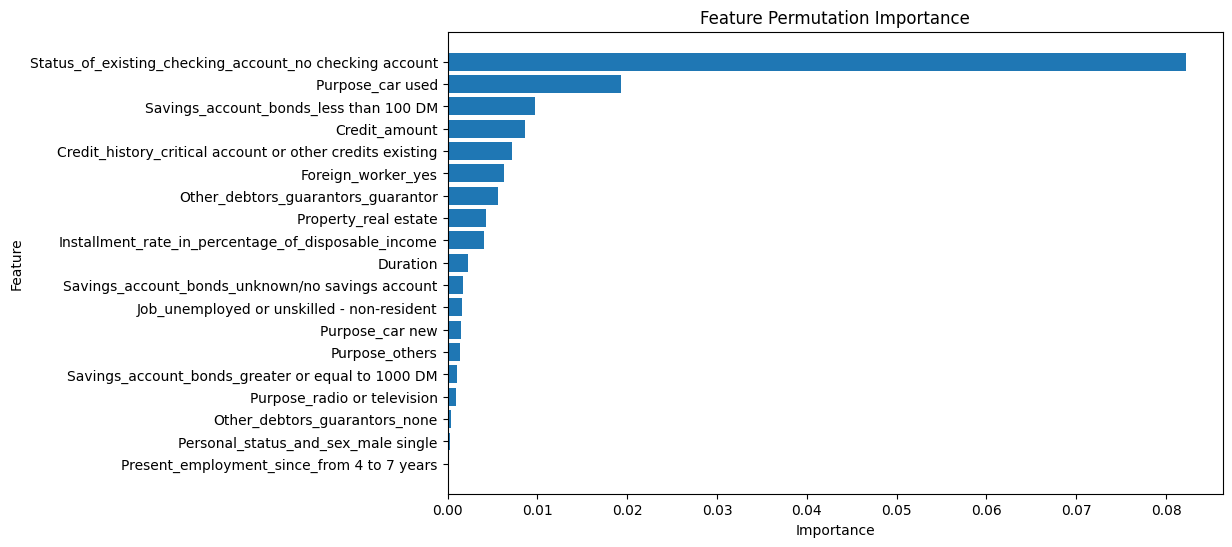

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio or television', 'Purpose_repairs', 'Purpose_retraining']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Purpose']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings

In [ ]:
lr_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   38  101   39  22      49.35   63.33        72.14      69.5     55.47   
1   45   84   56  15      44.55   75.00        60.00      64.5     55.90   
2   48   83   57  12      45.71   80.00        59.29      65.5     58.18   
3   50   66   74  10      40.32   83.33        47.14      58.0     54.35   
4   48   69   71  12      40.34   80.00        49.29      58.5     53.63   
5   53   47   93   7      36.30   88.33        33.57      50.0     51.46   
6   54   43   97   6      35.76   90.00        30.71      48.5     51.18   
7   55   41   99   5      35.71   91.67        29.29      48.0     51.40   
8   56   26  114   4      32.94   93.33        18.57      41.0     48.70   
9   56   19  121   4      31.64   93.33        13.57      37.5     47.26   
10  54   15  125   6      30.17   90.00        10.71      34.5     45.19   
11  55   21  119   5      31.61   91.67        15.00      38.0     47.01   
12  53   26  114   7      31.74   88.33        18.57      39.5     46.70   
13  59    5  135   1      30.41   98.33         3.57      32.0     46.46   
14  59    5  135   1      30.41   98.33         3.57      32.0     46.46   
15  59    6  134   1      30.57   98.33         4.29      32.5     46.64   
16  57    7  133   3      30.00   95.00         5.00      32.0     45.60   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.74                 0   
1               67.50                 1   
2               69.64                 2   
3               65.24                 3   
4               64.64                 4   
5               60.95                 5   
6               60.36                 6   
7               60.48                 7   
8               55.95                 8   
9               53.45                 9   
10              50.36                10   
11              53.33                11   
12              53.45                12   
13              50.95                13   
14              50.95                14   
15              51.31                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
lr_X_train.columns

Index(['Status_of_existing_checking_account_no checking account',
       'Status_of_existing_checking_account_less than 0 DM', 'Duration',
       'Credit_history_critical account or other credits existing',
       'Savings_account_bonds_less than 100 DM',
       'Savings_account_bonds_unknown/no savings account',
       'Credit_history_no credits taken or all credits paid back duly',
       'Housing_own', 'Credit_amount',
       'Present_employment_since_less than 1 year',
       'Property_unknown or no property', 'Property_real estate',
       'Purpose_car used', 'Housing_rent', 'Age',
       'Other_installment_plans_none',
       'Present_employment_since_from 4 to 7 years',
       'Personal_status_and_sex_male single',
       'Present_employment_since_greater or equal to 7 years',
       'Savings_account_bonds_greater or equal to 1000 DM',
       'Purpose_radio or television', 'Foreign_worker_yes',
       'Purpose_education',
       'Credit_history_existing credits paid back duly ti

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_german_cat_vars = [col for col in lr_X_train.columns if col in german_cat_vars]

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=lr_german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:45:29.589201

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Age', 'Number_of_existing_credits_at_this_bank', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since']
Categorical columns:  ['Status_of_existing_checking_account_no checking account', 'Status_of_existing_checking_account_less than 0 DM', 'Credit_history_critical account or other credits existing', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account', 'Credit_history_no credits taken or all credits paid back duly', 'Housing_own', 'Present_employment_since_less than 1 year', 'Property_unknown or n

In [ ]:
lr_perf_mf

tp   tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   38  101  39  22      49.35   63.33        72.14      69.5     55.47   
1   19  107  33  41      36.54   31.67        76.43      63.0     33.93   
2   19  110  30  41      38.78   31.67        78.57      64.5     34.86   
3   25  106  34  35      42.37   41.67        75.71      65.5     42.02   
4   24  106  34  36      41.38   40.00        75.71      65.0     40.68   
5   23   93  47  37      32.86   38.33        66.43      58.0     35.38   
6   23   90  50  37      31.51   38.33        64.29      56.5     34.59   
7   23   91  49  37      31.94   38.33        65.00      57.0     34.85   
8   25   75  65  35      27.78   41.67        53.57      50.0     33.33   
9   26   74  66  34      28.26   43.33        52.86      50.0     34.21   
10  16   74  66  44      19.51   26.67        52.86      45.0     22.54   
11  20   77  63  40      24.10   33.33        55.00      48.5     27.97   
12  30   58  82  30      26.79   50.00        41.43      44.0     34.88   
13  13  106  34  47      27.66   21.67        75.71      59.5     24.30   
14  18  101  39  42      31.58   30.00        72.14      59.5     30.77   
15  13  111  29  47      30.95   21.67        79.29      62.0     25.49   
16   1  132   8  59      11.11    1.67        94.29      66.5      2.90   
17   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
18   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
19   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
20   0  140   0  60       0.00    0.00       100.00      70.0      0.00   

    balanced_accuracy  num_feat_missing  \
0               67.74                 0   
1               54.05                 1   
2               55.12                 2   
3               58.69                 3   
4               57.86                 4   
5               52.38                 5   
6               51.31                 6   
7               51.67                 7   
8               47.62                 8   
9               48.10                 9   
10              39.76                10   
11              44.17                11   
12              45.71                12   
13              48.69                13   
14              51.07                14   
15              50.48                15   
16              47.98                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

# **Models optimized for Balanced Accuracy**

## **Decision Tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 0.005, 1]    # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [4],
      'min_samples_split': [0.1],
      'min_samples_leaf': [0.05],
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(dt2_classifier, dt2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train)

Starting hyperparameter tuning at: 2025-01-19 00:48:20.460558

Nested Cross-validation Results:
Individual scores: [0.7514881  0.66666667 0.69047619 0.77083333 0.73809524]
Average nested CV score: 0.724 (+/- 0.078)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.724

Train score: 0.731
Test score: 0.724
Train-test score difference: 0.008
2025-01-19 00:48:20.621456

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-15 00:28:04.159131

Nested Cross-validation Results:
Individual scores: [0.70386905 0.6889881  0.69047619 0.77083333 0.73809524]
Average nested CV score: 0.718 (+/- 0.063)

Fitting final model on entire dataset...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.724

Train score: 0.731
Test score: 0.724
Train-test score difference: 0.008
2025-01-15 00:28:30.387923

Execution time: 0.44 minutes
```

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.147321  0.018637
0                                            Duration    0.063571  0.001916
27             Savings_account_bonds_less than 100 DM    0.045060  0.011837
39                               Property_real estate    0.026905  0.008067
12  Credit_history_critical account or other credi...    0.020714  0.006013
7                                       Telephone_yes    0.016250  0.004488

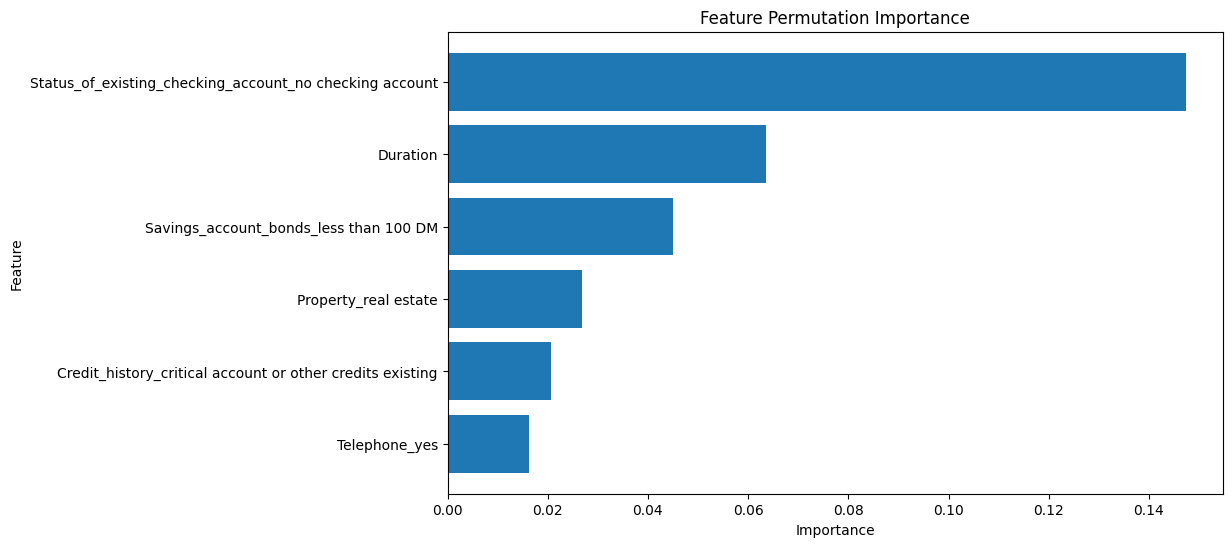

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Savings_account_bonds']

--- NEW ITERATION ---
Removing feature:  Property_real e

In [ ]:
dt2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  87   53  21      42.39   65.00        62.14      63.0     51.32   
1   50  59   81  10      38.17   83.33        42.14      54.5     52.36   
2   53  22  118   7      30.99   88.33        15.71      37.5     45.89   
3   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
4   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
5   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
6   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               63.57                 0   
1               62.74                 1   
2               52.02                 2   
3               50.00                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:48:21.189286

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
dt2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  87   53  21      42.39   65.00        62.14      63.0     51.32   
1   35  88   52  25      40.23   58.33        62.86      61.5     47.62   
2   33  83   57  27      36.67   55.00        59.29      58.0     44.00   
3   41  56   84  19      32.80   68.33        40.00      48.5     44.32   
4   44  45   95  16      31.65   73.33        32.14      44.5     44.22   
5   49  21  119  11      29.17   81.67        15.00      35.0     42.98   
6   49  22  118  11      29.34   81.67        15.71      35.5     43.17   
7   50  21  119  10      29.59   83.33        15.00      35.5     43.67   
8   55  20  120   5      31.43   91.67        14.29      37.5     46.81   
9   56  20  120   4      31.82   93.33        14.29      38.0     47.46   
10  56  21  119   4      32.00   93.33        15.00      38.5     47.66   
11  57  22  118   3      32.57   95.00        15.71      39.5     48.51   
12  57  27  113   3      33.53   95.00        19.29      42.0     49.57   
13  59   6  134   1      30.57   98.33         4.29      32.5     46.64   
14  59   8  132   1      30.89   98.33         5.71      33.5     47.01   
15  59   8  132   1      30.89   98.33         5.71      33.5     47.01   
16  59   8  132   1      30.89   98.33         5.71      33.5     47.01   
17  59   7  133   1      30.73   98.33         5.00      33.0     46.83   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               63.57                 0   
1               60.60                 1   
2               57.14                 2   
3               54.17                 3   
4               52.74                 4   
5               48.33                 5   
6               48.69                 6   
7               49.17                 7   
8               52.98                 8   
9               53.81                 9   
10              54.17                10   
11              55.36                11   
12              57.14                12   
13              51.31                13   
14              52.02                14   
15              52.02                15   
16              52.02                16   
17              51.67                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 2],
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 1]
  }
else:
  rf2_param_grid = {
    'n_estimators': [300],
    'max_features': ['sqrt'],
    'max_depth': [3],
    'min_samples_leaf': [0.01],
    'min_samples_split': [0.01],
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:51:09.192084

Nested Cross-validation Results:
Individual scores: [0.81994048 0.68005952 0.64880952 0.75892857 0.75446429]
Average nested CV score: 0.732 (+/- 0.122)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.732

Train score: 0.761
Test score: 0.732
Train-test score difference: 0.028
2025-01-19 00:51:14.443704

Execution time: 0.09 minutes


```
Starting hyperparameter tuning at: 2025-01-15 00:28:30.398217

Nested Cross-validation Results:
Individual scores: [0.82589286 0.69345238 0.64285714 0.72767857 0.69494048]
Average nested CV score: 0.717 (+/- 0.122)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.732

Train score: 0.761
Test score: 0.732
Train-test score difference: 0.028
2025-01-15 01:22:24.141755

Execution time: 53.90 minutes
```




In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.077798  0.018605
0                                            Duration    0.013512  0.004057
27             Savings_account_bonds_less than 100 DM    0.008512  0.005133
12  Credit_history_critical account or other credi...    0.007321  0.005981
17                                   Purpose_car used    0.004345  0.002473
44                                       Housing_rent    0.003274  0.002836
10  Status_of_existing_checking_account_less than ...    0.003274  0.003266
1                                       Credit_amount    0.003214  0.005091
39                               Property_real estate    0.003036  0.005221
28   Savings_account_bonds_unknown/no savings account    0.002679  0.001863
30  Present_employment_since_greater or equal to 7...    0.002560  0.002840
45                   Job_skilled employee or official    0.002500  0.003814
2   Installment_rate_in_percentage_of_disposable_i...    0.002024  0.002099
35                Personal_status_and_sex_male single    0.001845  0.002651
13     Credit_history_delay in paying off in the past    0.001786  0.000000
36                 Other_debtors_guarantors_guarantor    0.001607  0.000812
26  Savings_account_bonds_greater or equal to 1000 DM    0.001607  0.001679
29         Present_employment_since_from 4 to 7 years    0.001369  0.002325
25          Savings_account_bonds_from 500 to 1000 DM    0.001369  0.002271
14  Credit_history_existing credits paid back duly...    0.001131  0.001240
5             Number_of_existing_credits_at_this_bank    0.001131  0.002698
8                                  Foreign_worker_yes    0.000893  0.002121
31          Present_employment_since_less than 1 year    0.000595  0.001518
33  Personal_status_and_sex_male divorced or separ...    0.000298  0.001318
7                                       Telephone_yes   -0.000119  0.000767
20                     Purpose_furniture or equipment   -0.000179  0.000357
34    Personal_status_and_sex_male married or widowed   -0.000238  0.001534
16                                    Purpose_car new   -0.000357  0.001760
15  Credit_history_no credits taken or all credits...   -0.000417  0.001441
19                                  Purpose_education   -0.000655  0.000850
47                           Job_unskilled - resident   -0.000714  0.000357
6   Number_of_people_being_liable_to_provide_maint...   -0.000833  0.001021
38                              Property_car or other   -0.000833  0.001120
9   Status_of_existing_checking_account_greater or...   -0.001012  0.000357
42                     Other_installment_plans_stores   -0.001190  0.001176
32                Present_employment_since_unemployed   -0.001310  0.001007
4                                                 Age   -0.001369  0.001988
41                       Other_installment_plans_none   -0.001548  0.001858
3                             Present_residence_since   -0.001607  0.001352
22                        Purpose_radio or television   -0.002679  0.001564
40                    Property_unknown or no property   -0.003393  0.003068
43                                        Housing_own   -0.005536  0.004079

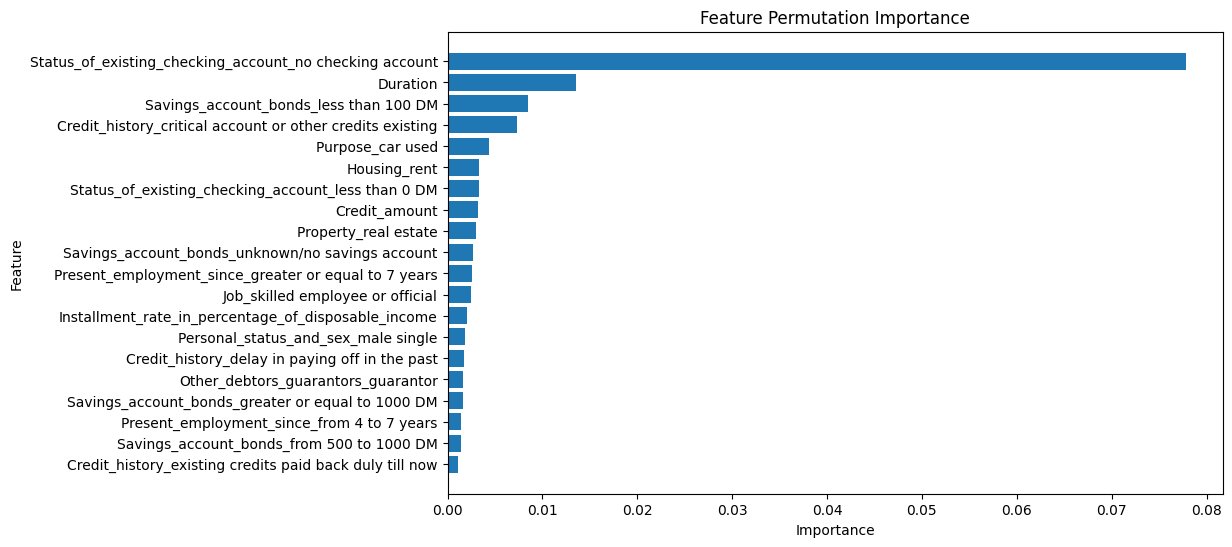

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Savings_account_bonds']

--- NEW ITERATION ---
Removing feature:  Credit_history_

In [ ]:
rf2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  97   43  21      47.56   65.00        69.29      68.0     54.93   
1   47  95   45  13      51.09   78.33        67.86      71.0     61.84   
2   47  82   58  13      44.76   78.33        58.57      64.5     56.97   
3   52  59   81   8      39.10   86.67        42.14      55.5     53.89   
4   55  27  113   5      32.74   91.67        19.29      41.0     48.25   
5   56  23  117   4      32.37   93.33        16.43      39.5     48.07   
6   55  26  114   5      32.54   91.67        18.57      40.5     48.03   
7   54  29  111   6      32.73   90.00        20.71      41.5     48.00   
8   60   8  132   0      31.25  100.00         5.71      34.0     47.62   
9   60   2  138   0      30.30  100.00         1.43      31.0     46.51   
10  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
11  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
12  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
13  60   2  138   0      30.30  100.00         1.43      31.0     46.51   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.14                 0   
1               73.10                 1   
2               68.45                 2   
3               64.40                 3   
4               55.48                 4   
5               54.88                 5   
6               55.12                 6   
7               55.36                 7   
8               52.86                 8   
9               50.71                 9   
10              51.07                10   
11              51.07                11   
12              51.07                12   
13              50.71                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:51:17.074862

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
rf2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  97   43  21      47.56   65.00        69.29      68.0     54.93   
1   37  87   53  23      41.11   61.67        62.14      62.0     49.33   
2   37  87   53  23      41.11   61.67        62.14      62.0     49.33   
3   45  54   86  15      34.35   75.00        38.57      49.5     47.12   
4   53  33  107   7      33.12   88.33        23.57      43.0     48.18   
5   46  30  110  14      29.49   76.67        21.43      38.0     42.59   
6   45  30  110  15      29.03   75.00        21.43      37.5     41.86   
7   45  29  111  15      28.85   75.00        20.71      37.0     41.67   
8   45  31  109  15      29.22   75.00        22.14      38.0     42.06   
9   44  29  111  16      28.39   73.33        20.71      36.5     40.93   
10  45  39  101  15      30.82   75.00        27.86      42.0     43.69   
11  41  43   97  19      29.71   68.33        30.71      42.0     41.41   
12  59   8  132   1      30.89   98.33         5.71      33.5     47.01   
13  58  10  130   2      30.85   96.67         7.14      34.0     46.77   
14  57  11  129   3      30.65   95.00         7.86      34.0     46.34   
15  57   9  131   3      30.32   95.00         6.43      33.0     45.97   
16  59   0  140   1      29.65   98.33         0.00      29.5     45.56   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.14                 0   
1               61.90                 1   
2               61.90                 2   
3               56.79                 3   
4               55.95                 4   
5               49.05                 5   
6               48.21                 6   
7               47.86                 7   
8               48.57                 8   
9               47.02                 9   
10              51.43                10   
11              49.52                11   
12              52.02                12   
13              51.90                13   
14              51.43                14   
15              50.71                15   
16              49.17                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Gradient Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [40, 8, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
    'n_estimators': [100],
    'max_depth': [None],
    'min_child_samples': [1],
    'min_split_gain': [0.5],
    'reg_lambda': [10.0]
}

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid,5, 5, 'balanced_accuracy', X_train,y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:54:00.334008

Nested Cross-validation Results:
Individual scores: [0.80654762 0.72172619 0.69940476 0.70386905 0.72172619]
Average nested CV score: 0.731 (+/- 0.078)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': None, 'min_child_samples': 1, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.731

Train score: 0.924
Test score: 0.731
Train-test score difference: 0.193
2025-01-19 00:54:00.647646

Execution time: 0.01 minutes


```
Starting hyperparameter tuning at: 2025-01-15 01:22:24.153415

Nested Cross-validation Results:
Individual scores: [0.79613095 0.71875    0.62202381 0.68452381 0.71279762]
Average nested CV score: 0.707 (+/- 0.113)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': None, 'min_child_samples': 1, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.731

Train score: 0.924
Test score: 0.731
Train-test score difference: 0.193
2025-01-15 01:26:29.052343

Execution time: 4.08 minutes
```




In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.143929  0.013073
1                                       Credit_amount    0.109107  0.007157
0                                            Duration    0.105060  0.009640
4                                                 Age    0.064048  0.005885
17                                   Purpose_car used    0.033452  0.004693
12  Credit_history_critical account or other credi...    0.029048  0.007680
29         Present_employment_since_from 4 to 7 years    0.022381  0.005431
3                             Present_residence_since    0.019702  0.003618
28   Savings_account_bonds_unknown/no savings account    0.018750  0.002934
10  Status_of_existing_checking_account_less than ...    0.017083  0.004647
41                       Other_installment_plans_none    0.016071  0.003144
31          Present_employment_since_less than 1 year    0.010179  0.001451
9   Status_of_existing_checking_account_greater or...    0.010119  0.002163
36                 Other_debtors_guarantors_guarantor    0.009405  0.002578
39                               Property_real estate    0.008631  0.002187
2   Installment_rate_in_percentage_of_disposable_i...    0.007262  0.000613
43                                        Housing_own    0.006548  0.003635
27             Savings_account_bonds_less than 100 DM    0.006012  0.001451
26  Savings_account_bonds_greater or equal to 1000 DM    0.005238  0.001721
16                                    Purpose_car new    0.004643  0.001271
8                                  Foreign_worker_yes    0.003036  0.001296
35                Personal_status_and_sex_male single    0.002619  0.001388
30  Present_employment_since_greater or equal to 7...    0.002262  0.001570
14  Credit_history_existing credits paid back duly...    0.001667  0.000833
45                   Job_skilled employee or official    0.001607  0.001536
5             Number_of_existing_credits_at_this_bank    0.001607  0.001041
40                    Property_unknown or no property    0.001548  0.001499
24                                 Purpose_retraining    0.001250  0.000437
25          Savings_account_bonds_from 500 to 1000 DM    0.001250  0.000437
22                        Purpose_radio or television    0.000714  0.002808
15  Credit_history_no credits taken or all credits...    0.000476  0.001326
13     Credit_history_delay in paying off in the past    0.000417  0.000833
33  Personal_status_and_sex_male divorced or separ...    0.000179  0.000357
19                                  Purpose_education    0.000119  0.000767
34    Personal_status_and_sex_male married or widowed   -0.000536  0.000437
44                                       Housing_rent   -0.002083  0.002298

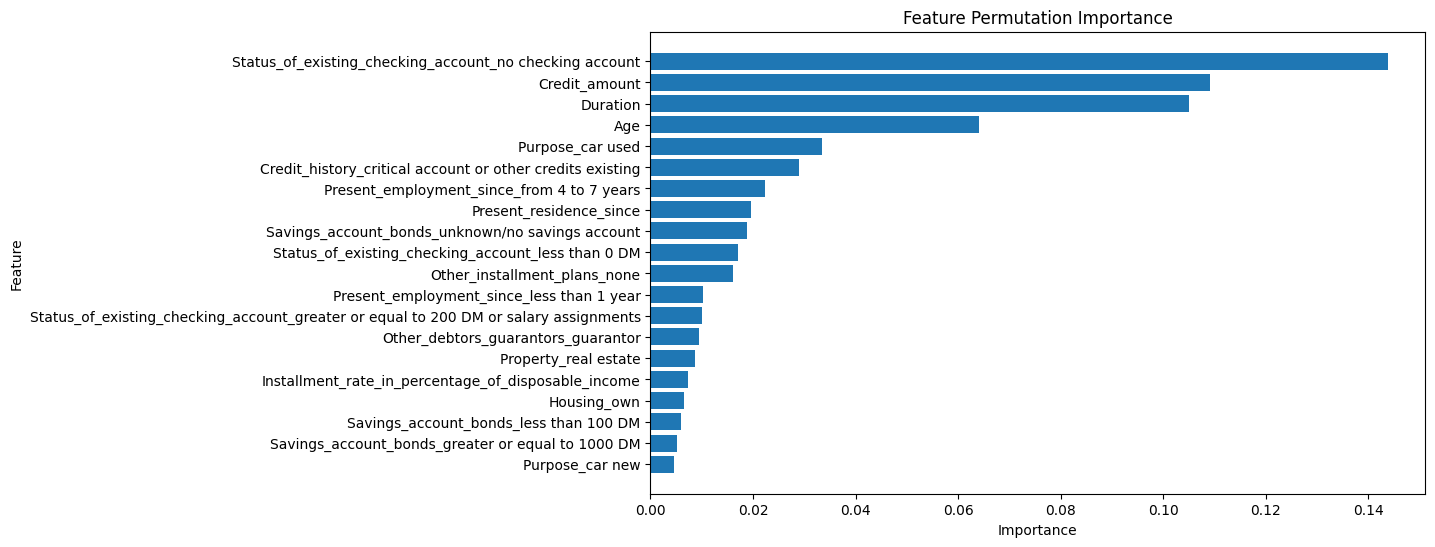

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount', 'Duration']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_amount', 'Duration', 'Age']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic applianc

In [ ]:
gbt2_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41  108   32  19      56.16   68.33        77.14      74.5     61.65   
1   45   91   49  15      47.87   75.00        65.00      68.0     58.44   
2   35   97   43  25      44.87   58.33        69.29      66.0     50.72   
3   35   92   48  25      42.17   58.33        65.71      63.5     48.95   
4   34   92   48  26      41.46   56.67        65.71      63.0     47.89   
5   37   93   47  23      44.05   61.67        66.43      65.0     51.39   
6   40   81   59  20      40.40   66.67        57.86      60.5     50.31   
7   48   62   78  12      38.10   80.00        44.29      55.0     51.61   
8   48   54   86  12      35.82   80.00        38.57      51.0     49.48   
9   59    9  131   1      31.05   98.33         6.43      34.0     47.20   
10  59    9  131   1      31.05   98.33         6.43      34.0     47.20   
11  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               72.74                 0   
1               70.00                 1   
2               63.81                 2   
3               62.02                 3   
4               61.19                 4   
5               64.05                 5   
6               62.26                 6   
7               62.14                 7   
8               59.29                 8   
9               52.38                 9   
10              52.38                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:54:01.549541

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
gbt2_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41  108   32  19      56.16   68.33        77.14      74.5     61.65   
1   37  101   39  23      48.68   61.67        72.14      69.0     54.41   
2   34  105   35  26      49.28   56.67        75.00      69.5     52.71   
3   33   92   48  27      40.74   55.00        65.71      62.5     46.81   
4   33   95   45  27      42.31   55.00        67.86      64.0     47.83   
5   29   92   48  31      37.66   48.33        65.71      60.5     42.34   
6   33   82   58  27      36.26   55.00        58.57      57.5     43.71   
7   35   89   51  25      40.70   58.33        63.57      62.0     47.95   
8   40   65   75  20      34.78   66.67        46.43      52.5     45.71   
9   41   31  109  19      27.33   68.33        22.14      36.0     39.05   
10  39   31  109  21      26.35   65.00        22.14      35.0     37.50   
11  39   30  110  21      26.17   65.00        21.43      34.5     37.32   
12  39   38  102  21      27.66   65.00        27.14      38.5     38.81   
13  40   42   98  20      28.99   66.67        30.00      41.0     40.40   
14  36   47   93  24      27.91   60.00        33.57      41.5     38.10   
15  36   47   93  24      27.91   60.00        33.57      41.5     38.10   
16  49   21  119  11      29.17   81.67        15.00      35.0     42.98   
17  52   18  122   8      29.89   86.67        12.86      35.0     44.44   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               72.74                 0   
1               66.90                 1   
2               65.83                 2   
3               60.36                 3   
4               61.43                 4   
5               57.02                 5   
6               56.79                 6   
7               60.95                 7   
8               56.55                 8   
9               45.24                 9   
10              43.57                10   
11              43.21                11   
12              46.07                12   
13              48.33                13   
14              46.79                14   
15              46.79                15   
16              48.33                16   
17              49.76                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb2_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'reg_lambda':[10.0],
      'gamma': [0.0],
      'colsample_bytree':[0.5]
  }

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:56:52.303919

Nested Cross-validation Results:
Individual scores: [0.81994048 0.70238095 0.67410714 0.6889881  0.76785714]
Average nested CV score: 0.731 (+/- 0.110)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.731

Train score: 0.841
Test score: 0.731
Train-test score difference: 0.110
2025-01-19 00:56:52.945869

Execution time: 0.01 minutes


```
Starting hyperparameter tuning at: 2025-01-14 19:04:55.854415

Nested Cross-validation Results:
Individual scores: [0.77529762 0.69047619 0.64434524 0.69196429 0.72767857]
Average nested CV score: 0.706 (+/- 0.087)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.731

Train score: 0.841
Test score: 0.731
Train-test score difference: 0.110
2025-01-14 19:29:45.630741

Execution time: 24.83 minutes

```



In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.065000  0.010572
0                                            Duration    0.051488  0.011163
1                                       Credit_amount    0.041369  0.011314
17                                   Purpose_car used    0.027440  0.008559
3                             Present_residence_since    0.016310  0.004376
4                                                 Age    0.014107  0.004332
29         Present_employment_since_from 4 to 7 years    0.012381  0.003349
12  Credit_history_critical account or other credi...    0.012262  0.008068
41                       Other_installment_plans_none    0.006845  0.002219
35                Personal_status_and_sex_male single    0.006071  0.001257
2   Installment_rate_in_percentage_of_disposable_i...    0.004821  0.005170
16                                    Purpose_car new    0.003810  0.001003
27             Savings_account_bonds_less than 100 DM    0.003452  0.003050
15  Credit_history_no credits taken or all credits...    0.003393  0.002408
36                 Other_debtors_guarantors_guarantor    0.003214  0.001388
8                                  Foreign_worker_yes    0.002798  0.001465
28   Savings_account_bonds_unknown/no savings account    0.002560  0.007167
20                     Purpose_furniture or equipment    0.001845  0.000985
43                                        Housing_own    0.001786  0.005949
19                                  Purpose_education    0.001786  0.001304
34    Personal_status_and_sex_male married or widowed    0.001429  0.000437
47                           Job_unskilled - resident    0.001131  0.001021
32                Present_employment_since_unemployed    0.000893  0.000000
30  Present_employment_since_greater or equal to 7...    0.000833  0.001932
44                                       Housing_rent    0.000655  0.003666
6   Number_of_people_being_liable_to_provide_maint...    0.000238  0.001296
39                               Property_real estate   -0.000417  0.004986
7                                       Telephone_yes   -0.000714  0.000989
45                   Job_skilled employee or official   -0.000774  0.000484
42                     Other_installment_plans_stores   -0.000893  0.000000
33  Personal_status_and_sex_male divorced or separ...   -0.001131  0.001426
13     Credit_history_delay in paying off in the past   -0.001905  0.000934
10  Status_of_existing_checking_account_less than ...   -0.002321  0.005013
40                    Property_unknown or no property   -0.004405  0.002270
31          Present_employment_since_less than 1 year   -0.005952  0.002848

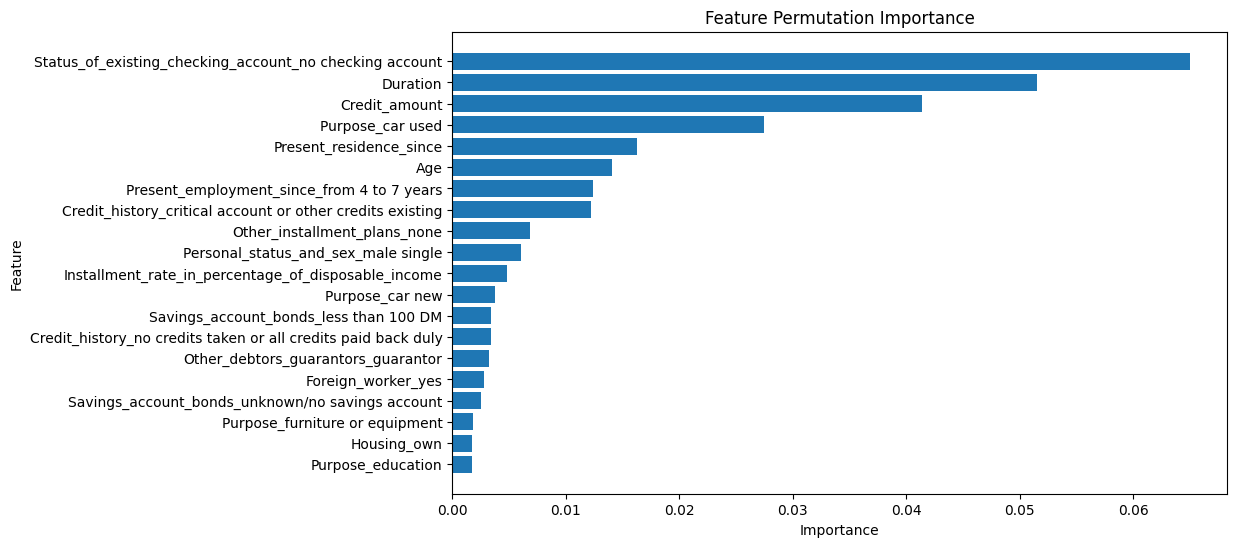

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio or television', 'Purpose_repairs', 'Purpose_retraining']
Original

In [ ]:
xgb2_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41  109   31  19      56.94   68.33        77.86      75.0     62.12   
1   43   95   45  17      48.86   71.67        67.86      69.0     58.11   
2   43   88   52  17      45.26   71.67        62.86      65.5     55.48   
3   34  104   36  26      48.57   56.67        74.29      69.0     52.31   
4   38  105   35  22      52.05   63.33        75.00      71.5     57.14   
5   39   93   47  21      45.35   65.00        66.43      66.0     53.42   
6   36   92   48  24      42.86   60.00        65.71      64.0     50.00   
7   40   87   53  20      43.01   66.67        62.14      63.5     52.29   
8   47   57   83  13      36.15   78.33        40.71      52.0     49.47   
9   47   60   80  13      37.01   78.33        42.86      53.5     50.27   
10  42   65   75  18      35.90   70.00        46.43      53.5     47.46   
11  48   49   91  12      34.53   80.00        35.00      48.5     48.24   
12  55   23  117   5      31.98   91.67        16.43      39.0     47.41   
13  56   16  124   4      31.11   93.33        11.43      36.0     46.67   
14  57    8  132   3      30.16   95.00         5.71      32.5     45.78   
15  56    9  131   4      29.95   93.33         6.43      32.5     45.34   
16  54   15  125   6      30.17   90.00        10.71      34.5     45.19   
17  54   16  124   6      30.34   90.00        11.43      35.0     45.38   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.10                 0   
1               69.76                 1   
2               67.26                 2   
3               65.48                 3   
4               69.17                 4   
5               65.71                 5   
6               62.86                 6   
7               64.40                 7   
8               59.52                 8   
9               60.60                 9   
10              58.21                10   
11              57.50                11   
12              54.05                12   
13              52.38                13   
14              50.36                14   
15              49.88                15   
16              50.36                16   
17              50.71                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:56:54.291369

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
xgb2_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   41  109   31  19      56.94   68.33        77.86      75.0     62.12   
1   40   99   41  20      49.38   66.67        70.71      69.5     56.74   
2   37   95   45  23      45.12   61.67        67.86      66.0     52.11   
3   31   99   41  29      43.06   51.67        70.71      65.0     46.97   
4   27   93   47  33      36.49   45.00        66.43      60.0     40.30   
5   28   94   46  32      37.84   46.67        67.14      61.0     41.79   
6   28   86   54  32      34.15   46.67        61.43      57.0     39.44   
7   33   94   46  27      41.77   55.00        67.14      63.5     47.48   
8   39   78   62  21      38.61   65.00        55.71      58.5     48.45   
9   35   77   63  25      35.71   58.33        55.00      56.0     44.30   
10  34   81   59  26      36.56   56.67        57.86      57.5     44.44   
11  32   81   59  28      35.16   53.33        57.86      56.5     42.38   
12  42   44   96  18      30.43   70.00        31.43      43.0     42.42   
13  42   44   96  18      30.43   70.00        31.43      43.0     42.42   
14  43   38  102  17      29.66   71.67        27.14      40.5     41.95   
15  36   42   98  24      26.87   60.00        30.00      39.0     37.11   
16  40   45   95  20      29.63   66.67        32.14      42.5     41.03   
17  42   47   93  18      31.11   70.00        33.57      44.5     43.08   
18  51   19  121   9      29.65   85.00        13.57      35.0     43.97   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.10                 0   
1               68.69                 1   
2               64.76                 2   
3               61.19                 3   
4               55.71                 4   
5               56.90                 5   
6               54.05                 6   
7               61.07                 7   
8               60.36                 8   
9               56.67                 9   
10              57.26                10   
11              55.60                11   
12              50.71                12   
13              50.71                13   
14              49.40                14   
15              45.00                15   
16              49.40                16   
17              51.79                17   
18              49.29                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.05, 0.01, 2],
      'min_samples_leaf': [0.05, 0.01, 1]
  }
else:
  et2_param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'max_features':[0.5],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01],
}

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 00:59:44.201793

Nested Cross-validation Results:
Individual scores: [0.80505952 0.72470238 0.64880952 0.72619048 0.77232143]
Average nested CV score: 0.735 (+/- 0.105)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.735

Train score: 0.886
Test score: 0.735
Train-test score difference: 0.150
2025-01-19 00:59:49.320395

Execution time: 0.09 minutes


```
Starting hyperparameter tuning at: 2025-01-15 01:26:29.062872

Nested Cross-validation Results:
Individual scores: [0.76488095 0.67559524 0.66964286 0.7172619  0.7172619 ]
Average nested CV score: 0.709 (+/- 0.069)

Fitting final model on entire dataset...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.735

Train score: 0.886
Test score: 0.735
Train-test score difference: 0.150
2025-01-15 02:05:28.223710

Execution time: 38.99 minutes
```




In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.177738  0.019727
12  Credit_history_critical account or other credi...    0.047321  0.010277
0                                            Duration    0.046726  0.007071
28   Savings_account_bonds_unknown/no savings account    0.036131  0.008924
39                               Property_real estate    0.036131  0.005136
10  Status_of_existing_checking_account_less than ...    0.025714  0.002385
27             Savings_account_bonds_less than 100 DM    0.025000  0.005765
9   Status_of_existing_checking_account_greater or...    0.020476  0.006227
41                       Other_installment_plans_none    0.020119  0.005269
31          Present_employment_since_less than 1 year    0.015179  0.003362
35                Personal_status_and_sex_male single    0.013452  0.001310
1                                       Credit_amount    0.011845  0.001268
7                                       Telephone_yes    0.010655  0.004624
36                 Other_debtors_guarantors_guarantor    0.010357  0.001677
30  Present_employment_since_greater or equal to 7...    0.010179  0.003316
2   Installment_rate_in_percentage_of_disposable_i...    0.010179  0.001867
38                              Property_car or other    0.010119  0.002251
45                   Job_skilled employee or official    0.008571  0.002801
17                                   Purpose_car used    0.007143  0.003029
3                             Present_residence_since    0.006548  0.002760
37                      Other_debtors_guarantors_none    0.006548  0.001458
40                    Property_unknown or no property    0.005238  0.001107
5             Number_of_existing_credits_at_this_bank    0.005060  0.003393
29         Present_employment_since_from 4 to 7 years    0.004821  0.002074
20                     Purpose_furniture or equipment    0.004762  0.000799
22                        Purpose_radio or television    0.004762  0.001715
14  Credit_history_existing credits paid back duly...    0.003750  0.002356
16                                    Purpose_car new    0.002976  0.001541
43                                        Housing_own    0.002679  0.002290
34    Personal_status_and_sex_male married or widowed    0.002262  0.000583
4                                                 Age    0.001964  0.002176
6   Number_of_people_being_liable_to_provide_maint...    0.001786  0.000565
44                                       Housing_rent    0.001607  0.000668
42                     Other_installment_plans_stores    0.001310  0.000833
13     Credit_history_delay in paying off in the past    0.000714  0.000357
26  Savings_account_bonds_greater or equal to 1000 DM    0.000536  0.000714
8                                  Foreign_worker_yes   -0.000179  0.000357
25          Savings_account_bonds_from 500 to 1000 DM   -0.000179  0.000357
47                           Job_unskilled - resident   -0.000417  0.001441

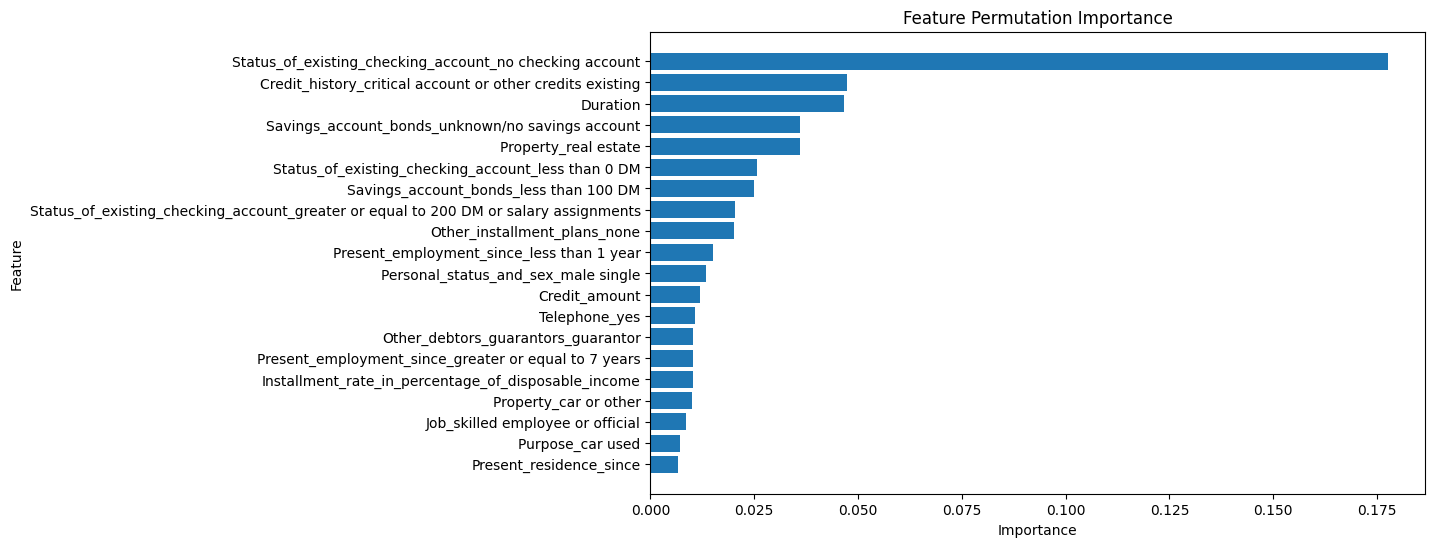

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Credit_history_critical account or other credits existing
Removing related features:  ['Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Credit_history_existing credits paid back duly till now', 'Credit_history_no credits taken or all credits paid back duly']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_history']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Credit_history', 'Duratio

In [ ]:
et2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  97   43  20      48.19   66.67        69.29      68.5     55.94   
1   45  77   63  15      41.67   75.00        55.00      61.0     53.57   
2   49  64   76  11      39.20   81.67        45.71      56.5     52.97   
3   49  55   85  11      36.57   81.67        39.29      52.0     50.52   
4   59  11  129   1      31.38   98.33         7.86      35.0     47.58   
5   60   6  134   0      30.93  100.00         4.29      33.0     47.24   
6   60   7  133   0      31.09  100.00         5.00      33.5     47.43   
7   60   9  131   0      31.41  100.00         6.43      34.5     47.81   
8   60   9  131   0      31.41  100.00         6.43      34.5     47.81   
9   60   9  131   0      31.41  100.00         6.43      34.5     47.81   
10  60   9  131   0      31.41  100.00         6.43      34.5     47.81   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.98                 0   
1               65.00                 1   
2               63.69                 2   
3               60.48                 3   
4               53.10                 4   
5               52.14                 5   
6               52.50                 6   
7               53.21                 7   
8               53.21                 8   
9               53.21                 9   
10              53.21                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 00:59:53.085949

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
et2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  97   43  20      48.19   66.67        69.29      68.5     55.94   
1   39  91   49  21      44.32   65.00        65.00      65.0     52.70   
2   45  72   68  15      39.82   75.00        51.43      58.5     52.02   
3   45  73   67  15      40.18   75.00        52.14      59.0     52.33   
4   51  43   97   9      34.46   85.00        30.71      47.0     49.04   
5   48  31  109  12      30.57   80.00        22.14      39.5     44.24   
6   50  34  106  10      32.05   83.33        24.29      42.0     46.30   
7   51  36  104   9      32.90   85.00        25.71      43.5     47.44   
8   55  32  108   5      33.74   91.67        22.86      43.5     49.33   
9   55  31  109   5      33.54   91.67        22.14      43.0     49.11   
10  53  24  116   7      31.36   88.33        17.14      38.5     46.29   
11  53  17  123   7      30.11   88.33        12.14      35.0     44.92   
12  52  17  123   8      29.71   86.67        12.14      34.5     44.26   
13  58  11  129   2      31.02   96.67         7.86      34.5     46.96   
14  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
15  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
16  60   3  137   0      30.46  100.00         2.14      31.5     46.69   
17  60   4  136   0      30.61  100.00         2.86      32.0     46.88   
18  60   4  136   0      30.61  100.00         2.86      32.0     46.88   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.98                 0   
1               65.00                 1   
2               63.21                 2   
3               63.57                 3   
4               57.86                 4   
5               51.07                 5   
6               53.81                 6   
7               55.36                 7   
8               57.26                 8   
9               56.90                 9   
10              52.74                10   
11              50.24                11   
12              49.40                12   
13              52.26                13   
14              51.07                14   
15              51.07                15   
16              51.07                16   
17              51.43                17   
18              51.43                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm2_param_grid = {
    'C': [0.1],
    'kernel': ['linear'],
    'gamma': ['scale'],
    'degree': [2]
}

svm2_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 5, 5, 'balanced_accuracy', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:02:48.955725

Nested Cross-validation Results:
Individual scores: [0.75892857 0.68303571 0.70684524 0.7202381  0.70386905]
Average nested CV score: 0.715 (+/- 0.050)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.715

Train score: 0.748
Test score: 0.715
Train-test score difference: 0.033
2025-01-19 01:02:49.175920

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-14 20:08:24.606651

Nested Cross-validation Results:
Individual scores: [0.73511905 0.64583333 0.70684524 0.7202381  0.71428571]
Average nested CV score: 0.704 (+/- 0.062)

Fitting final model on entire dataset...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.715

Train score: 0.748
Test score: 0.715
Train-test score difference: 0.033
2025-01-14 20:10:43.876623

Execution time: 2.32 minutes
```





In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(svm2_classifier, X_train_scaled, y_train, scoring_metric="balanced_accuracy")
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
11  Status_of_existing_checking_account_no checkin...  8.434524e-02  0.012591
10  Status_of_existing_checking_account_less than ...  5.595238e-03  0.005241
28   Savings_account_bonds_unknown/no savings account  4.464286e-03  0.002940
36                 Other_debtors_guarantors_guarantor  4.464286e-03  0.004305
29         Present_employment_since_from 4 to 7 years  4.464286e-03  0.004795
17                                   Purpose_car used  3.630952e-03  0.003463
1                                       Credit_amount  3.333333e-03  0.003498
47                           Job_unskilled - resident  3.273810e-03  0.002695
8                                  Foreign_worker_yes  3.035714e-03  0.002665
40                    Property_unknown or no property  3.035714e-03  0.001475
12  Credit_history_critical account or other credi...  2.976190e-03  0.008331
0                                            Duration  2.678571e-03  0.004991
33  Personal_status_and_sex_male divorced or separ...  2.619048e-03  0.001750
38                              Property_car or other  1.309524e-03  0.001711
23                                    Purpose_repairs  8.928571e-04  0.000978
21                                     Purpose_others  8.928571e-04  0.000000
43                                        Housing_own  6.547619e-04  0.001545
26  Savings_account_bonds_greater or equal to 1000 DM  5.952381e-04  0.002649
15  Credit_history_no credits taken or all credits...  4.166667e-04  0.001271
9   Status_of_existing_checking_account_greater or...  4.166667e-04  0.002459
46         Job_unemployed or unskilled - non-resident  1.785714e-04  0.000668
30  Present_employment_since_greater or equal to 7... -8.881784e-17  0.002728
44                                       Housing_rent -5.952381e-05  0.001226
20                     Purpose_furniture or equipment -5.952381e-05  0.000663
4                                                 Age -2.380952e-04  0.003311
13     Credit_history_delay in paying off in the past -3.571429e-04  0.000714
32                Present_employment_since_unemployed -4.166667e-04  0.000833
19                                  Purpose_education -4.166667e-04  0.000952
25          Savings_account_bonds_from 500 to 1000 DM -4.761905e-04  0.002151
24                                 Purpose_retraining -7.142857e-04  0.000668
34    Personal_status_and_sex_male married or widowed -8.928571e-04  0.000000
14  Credit_history_existing credits paid back duly... -1.011905e-03  0.001285
6   Number_of_people_being_liable_to_provide_maint... -1.666667e-03  0.001811
41                       Other_installment_plans_none -2.023810e-03  0.001677
42                     Other_installment_plans_stores -2.023810e-03  0.002671
7                                       Telephone_yes -2.202381e-03  0.003153
39                               Property_real estate -2.500000e-03  0.002363
37                      Other_debtors_guarantors_none -2.857143e-03  0.004364
22                        Purpose_radio or television -2.976190e-03  0.000000
2   Installment_rate_in_percentage_of_disposable_i... -3.630952e-03  0.002730
31          Present_employment_since_less than 1 year -3.630952e-03  0.001055
3                             Present_residence_since -4.107143e-03  0.002698
27             Savings_account_bonds_less than 100 DM -4.464286e-03  0.003461
16                                    Purpose_car new -5.119048e-03  0.004999
45                   Job_skilled employee or official -5.357143e-03  0.004430
35                Personal_status_and_sex_male single -7.559524e-03  0.005418

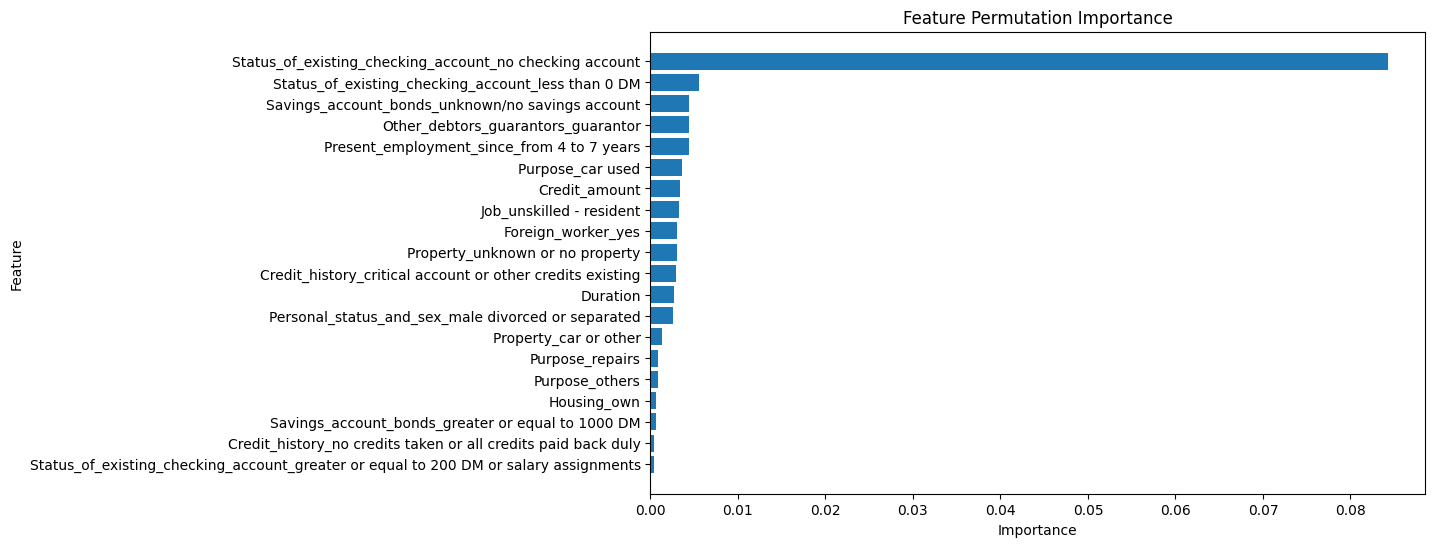

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_unknown/no savings account
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Savings_account_bonds']

--- NEW ITERATION ---
Removing feature:  Other_debtors_guarantors_guarantor
Removing related features:  ['Other_debtors_guarantors_guarantor', 'Other_debtors_guarantors_

In [ ]:
svm2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  97   43  20      48.19   66.67        69.29      68.5     55.94   
1   46  81   59  14      43.81   76.67        57.86      63.5     55.76   
2   52  65   75   8      40.94   86.67        46.43      58.5     55.61   
3   52  65   75   8      40.94   86.67        46.43      58.5     55.61   
4   56  54   86   4      39.44   93.33        38.57      55.0     55.45   
5   55  43   97   5      36.18   91.67        30.71      49.0     51.89   
6   54  45   95   6      36.24   90.00        32.14      49.5     51.67   
7   53  49   91   7      36.81   88.33        35.00      51.0     51.96   
8   54  46   94   6      36.49   90.00        32.86      50.0     51.92   
9   55  36  104   5      34.59   91.67        25.71      45.5     50.23   
10  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
11  59   0  140   1      29.65   98.33         0.00      29.5     45.56   
12  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
13  58   3  137   2      29.74   96.67         2.14      30.5     45.49   
14  58   3  137   2      29.74   96.67         2.14      30.5     45.49   
15  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
16  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
17  57   2  138   3      29.23   95.00         1.43      29.5     44.71   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.98                 0   
1               67.26                 1   
2               66.55                 2   
3               66.55                 3   
4               65.95                 4   
5               61.19                 5   
6               61.07                 6   
7               61.67                 7   
8               61.43                 8   
9               58.69                 9   
10              50.24                10   
11              49.17                11   
12              50.24                12   
13              49.40                13   
14              49.40                14   
15              49.88                15   
16              49.88                16   
17              48.21                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:02:50.311901

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
svm2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  97   43  20      48.19   66.67        69.29      68.5     55.94   
1   39  82   58  21      40.21   65.00        58.57      60.5     49.68   
2   45  58   82  15      35.43   75.00        41.43      51.5     48.13   
3   46  60   80  14      36.51   76.67        42.86      53.0     49.46   
4   46  59   81  14      36.22   76.67        42.14      52.5     49.20   
5   43  48   92  17      31.85   71.67        34.29      45.5     44.10   
6   44  47   93  16      32.12   73.33        33.57      45.5     44.67   
7   46  51   89  14      34.07   76.67        36.43      48.5     47.18   
8   46  47   93  14      33.09   76.67        33.57      46.5     46.23   
9   49  23  117  11      29.52   81.67        16.43      36.0     43.36   
10  52  23  117   8      30.77   86.67        16.43      37.5     45.41   
11  53  18  122   7      30.29   88.33        12.86      35.5     45.11   
12  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
13  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
14  60   1  139   0      30.15  100.00         0.71      30.5     46.33   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.98                 0   
1               61.79                 1   
2               58.21                 2   
3               59.76                 3   
4               59.40                 4   
5               52.98                 5   
6               53.45                 6   
7               56.55                 7   
8               55.12                 8   
9               49.05                 9   
10              51.55                10   
11              50.60                11   
12              50.36                12   
13              50.36                13   
14              50.36                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Logistic Regression**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm for optimization
  }
else:
  # best model
  lr2_param_grid = {
    'C': [1.0],
    'penalty': ['l1'],
    'solver': ['liblinear']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 5, 5, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:05:44.201192

Nested Cross-validation Results:
Individual scores: [0.78720238 0.70089286 0.71577381 0.7202381  0.69494048]
Average nested CV score: 0.724 (+/- 0.066)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.724

Train score: 0.756
Test score: 0.724
Train-test score difference: 0.032
2025-01-19 01:05:44.379487

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-15 02:05:28.236740

Nested Cross-validation Results:
Individual scores: [0.76785714 0.67559524 0.68452381 0.70982143 0.71428571]
Average nested CV score: 0.710 (+/- 0.064)

Fitting final model on entire dataset...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.724

Train score: 0.756
Test score: 0.724
Train-test score difference: 0.032
2025-01-15 02:05:35.606435

Execution time: 0.12 minutes
```




In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0   Status_of_existing_checking_account_no checkin...    0.069702  0.012444
12                                   Purpose_car used    0.016726  0.006298
4              Savings_account_bonds_less than 100 DM    0.008393  0.005335
8                                       Credit_amount    0.007381  0.004800
3   Credit_history_critical account or other credi...    0.006488  0.006584
21                                 Foreign_worker_yes    0.005536  0.003108
34                 Other_debtors_guarantors_guarantor    0.004762  0.003926
11                               Property_real estate    0.003452  0.005677
28  Installment_rate_in_percentage_of_disposable_i...    0.003095  0.005525
2                                            Duration    0.001845  0.008117
5    Savings_account_bonds_unknown/no savings account    0.001607  0.005464
47         Job_unemployed or unskilled - non-resident    0.001369  0.001352
33                                     Purpose_others    0.001250  0.001021
25                                    Purpose_car new    0.001071  0.006304
19  Savings_account_bonds_greater or equal to 1000 DM    0.000893  0.001145
16         Present_employment_since_from 4 to 7 years    0.000714  0.005696
20                        Purpose_radio or television    0.000595  0.000565
17                Personal_status_and_sex_male single    0.000298  0.002251
38                      Other_debtors_guarantors_none    0.000238  0.002838
27            Number_of_existing_credits_at_this_bank   -0.000179  0.001365
15                       Other_installment_plans_none   -0.000298  0.004081
22                                  Purpose_education   -0.000833  0.001624
6   Credit_history_no credits taken or all credits...   -0.000952  0.001800
46                           Job_unskilled - resident   -0.000952  0.000985
26                                 Purpose_retraining   -0.001012  0.000404
7                                         Housing_own   -0.001012  0.005693
10                    Property_unknown or no property   -0.001190  0.002766
9           Present_employment_since_less than 1 year   -0.001667  0.003333
29  Personal_status_and_sex_male divorced or separ...   -0.001726  0.001451
36                                    Purpose_repairs   -0.001786  0.001766
32                                      Telephone_yes   -0.001845  0.005006
1   Status_of_existing_checking_account_less than ...   -0.001905  0.006659
13                                       Housing_rent   -0.002321  0.002906
40                     Purpose_furniture or equipment   -0.002560  0.001934
41    Personal_status_and_sex_male married or widowed   -0.002619  0.000714
14                                                Age   -0.003274  0.004836
44     Credit_history_delay in paying off in the past   -0.003929  0.002399
30                   Job_skilled employee or official   -0.003988  0.003514
45  Number_of_people_being_liable_to_provide_maint...   -0.004345  0.001513
18  Present_employment_since_greater or equal to 7...   -0.004345  0.003833
39                            Present_residence_since   -0.004405  0.004164
35  Status_of_existing_checking_account_greater or...   -0.004702  0.003406

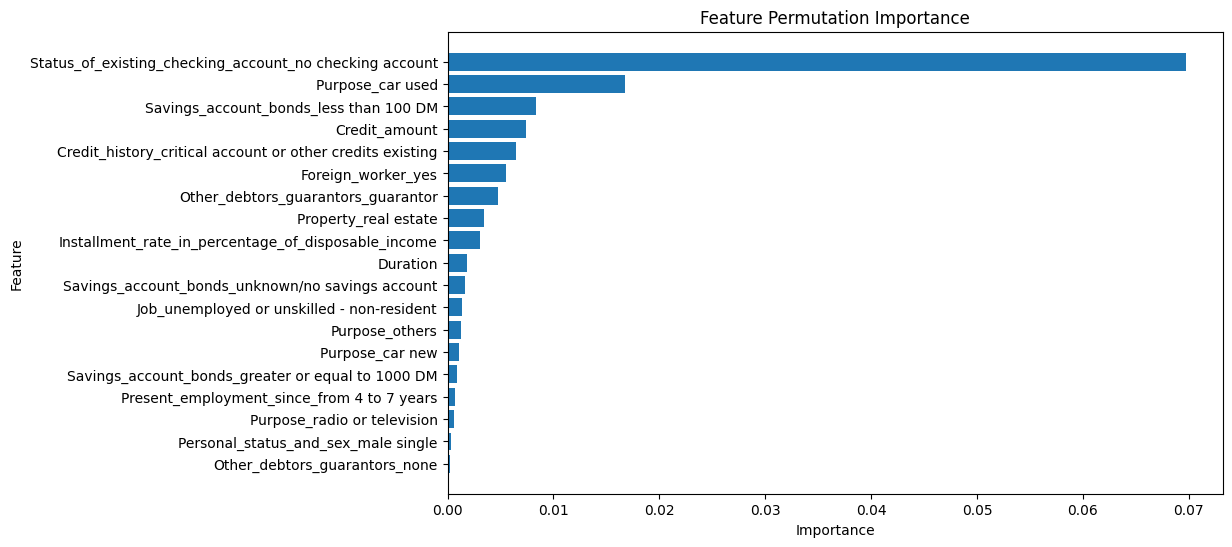

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio or television', 'Purpose_repairs', 'Purpose_retraining']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Purpose']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings

In [ ]:
lr2_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   38  101   39  22      49.35   63.33        72.14      69.5     55.47   
1   45   84   56  15      44.55   75.00        60.00      64.5     55.90   
2   48   83   57  12      45.71   80.00        59.29      65.5     58.18   
3   50   66   74  10      40.32   83.33        47.14      58.0     54.35   
4   48   69   71  12      40.34   80.00        49.29      58.5     53.63   
5   53   47   93   7      36.30   88.33        33.57      50.0     51.46   
6   54   43   97   6      35.76   90.00        30.71      48.5     51.18   
7   55   41   99   5      35.71   91.67        29.29      48.0     51.40   
8   56   26  114   4      32.94   93.33        18.57      41.0     48.70   
9   56   19  121   4      31.64   93.33        13.57      37.5     47.26   
10  54   15  125   6      30.17   90.00        10.71      34.5     45.19   
11  55   21  119   5      31.61   91.67        15.00      38.0     47.01   
12  59    2  138   1      29.95   98.33         1.43      30.5     45.91   
13  59    5  135   1      30.41   98.33         3.57      32.0     46.46   
14  59    5  135   1      30.41   98.33         3.57      32.0     46.46   
15  59    6  134   1      30.57   98.33         4.29      32.5     46.64   
16  57    7  133   3      30.00   95.00         5.00      32.0     45.60   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               67.74                 0   
1               67.50                 1   
2               69.64                 2   
3               65.24                 3   
4               64.64                 4   
5               60.95                 5   
6               60.36                 6   
7               60.48                 7   
8               55.95                 8   
9               53.45                 9   
10              50.36                10   
11              53.33                11   
12              49.88                12   
13              50.95                13   
14              50.95                14   
15              51.31                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=lr_german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:05:45.150706

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Age', 'Number_of_existing_credits_at_this_bank', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since']
Categorical columns:  ['Status_of_existing_checking_account_no checking account', 'Status_of_existing_checking_account_less than 0 DM', 'Credit_history_critical account or other credits existing', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account', 'Credit_history_no credits taken or all credits paid back duly', 'Housing_own', 'Present_employment_since_less than 1 year', 'Property_unknown or n

In [ ]:
lr2_perf_mf

tp   tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   38  101  39  22      49.35   63.33        72.14      69.5     55.47   
1   19  107  33  41      36.54   31.67        76.43      63.0     33.93   
2   19  110  30  41      38.78   31.67        78.57      64.5     34.86   
3   25  106  34  35      42.37   41.67        75.71      65.5     42.02   
4   24  106  34  36      41.38   40.00        75.71      65.0     40.68   
5   23   93  47  37      32.86   38.33        66.43      58.0     35.38   
6   23   90  50  37      31.51   38.33        64.29      56.5     34.59   
7   23   91  49  37      31.94   38.33        65.00      57.0     34.85   
8   25   75  65  35      27.78   41.67        53.57      50.0     33.33   
9   26   74  66  34      28.26   43.33        52.86      50.0     34.21   
10  16   74  66  44      19.51   26.67        52.86      45.0     22.54   
11  20   77  63  40      24.10   33.33        55.00      48.5     27.97   
12  20   98  42  40      32.26   33.33        70.00      59.0     32.79   
13  13  106  34  47      27.66   21.67        75.71      59.5     24.30   
14  18  101  39  42      31.58   30.00        72.14      59.5     30.77   
15  13  111  29  47      30.95   21.67        79.29      62.0     25.49   
16   1  132   8  59      11.11    1.67        94.29      66.5      2.90   
17   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
18   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
19   0  140   0  60       0.00    0.00       100.00      70.0      0.00   
20   0  140   0  60       0.00    0.00       100.00      70.0      0.00   

    balanced_accuracy  num_feat_missing  \
0               67.74                 0   
1               54.05                 1   
2               55.12                 2   
3               58.69                 3   
4               57.86                 4   
5               52.38                 5   
6               51.31                 6   
7               51.67                 7   
8               47.62                 8   
9               48.10                 9   
10              39.76                10   
11              44.17                11   
12              51.67                12   
13              48.69                13   
14              51.07                14   
15              50.48                15   
16              47.98                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

# **Results comparison**

## **F1-score**

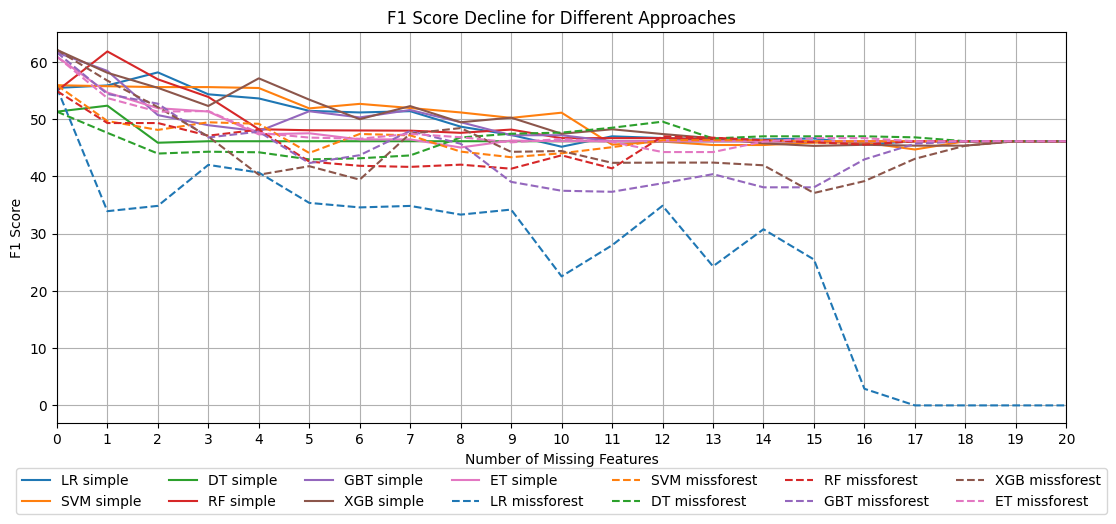

In [ ]:
# Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

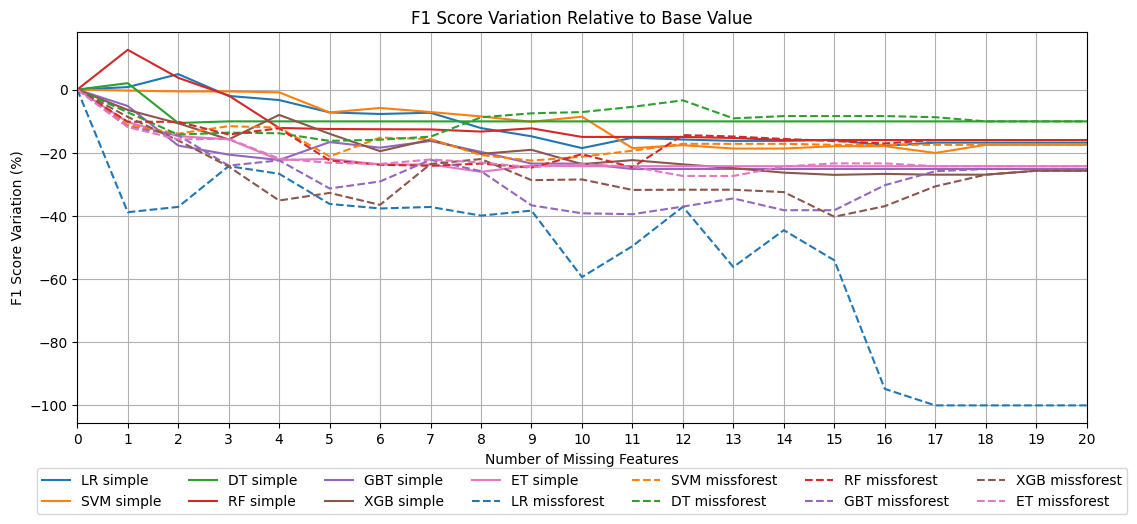

In [ ]:
# Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced accuracy**

In [ ]:
# Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

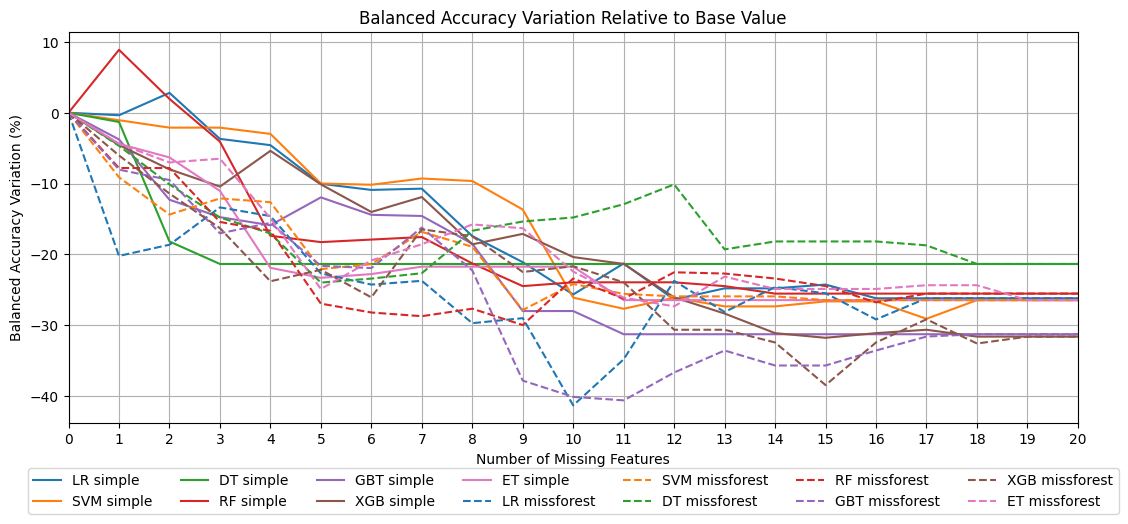

In [ ]:
# Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In this dataset there are few highly correlated variables (even considerind the ohe). So the ensemble models like Random Forests and Extra Trees do not benefit from the power of backup variables because they actually do not exist.

From the analysis of F1 and Balanced Accuracy, Decision Trees and XGBoost seem to be the less resilient to features missing.

# **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf,
}

all_data = combine_datasets(
    dataset_dict, 'German Credit', 'Scenario 1: standard', RANDOM_STATE
)
save_dataset(all_data, 'german_credit_scenario1_seed_2024.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0    38  101   39  22      49.35   63.33        72.14      69.5     55.47   
1    45   84   56  15      44.55   75.00        60.00      64.5     55.90   
2    48   83   57  12      45.71   80.00        59.29      65.5     58.18   
3    50   66   74  10      40.32   83.33        47.14      58.0     54.35   
4    48   69   71  12      40.34   80.00        49.29      58.5     53.63   
..   ..  ...  ...  ..        ...     ...          ...       ...       ...   
583  60    3  137   0      30.46  100.00         2.14      31.5     46.69   
584  60    4  136   0      30.61  100.00         2.86      32.0     46.88   
585  60    4  136   0      30.61  100.00         2.86      32.0     46.88   
586  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
587  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

     balanced_accuracy  num_feat_missing  \
0                67.74                 0   
1                67.50                 1   
2                69.64                 2   
3                65.24                 3   
4                64.64                 4   
..                 ...               ...   
583              51.07                16   
584              51.43                17   
585              51.43                18   
586              50.00                19   
587              50.00                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1    ['Status_of_existing_checking_account_greater ...      lr_perf   
2    ['Status_of_existing_checking_account_greater ...      lr_perf   
3    ['Status_of_existing_checking_account_greater ...      lr_perf   
4    ['Status_of_existing_checking_account_greater ...      lr_perf   
..                                                 ...          ...   
583  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
584  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
585  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
586  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
587  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   

            source              scenario  random_state             metric  
0    German Credit  Scenario 1: standard          2024           f1 score  
1    German Credit  Scenario 1: standard          2024           f1 score  
2    German Credit  Scenario 1: standard          2024           f1 score  
3    German Credit  Scenario 1: standard          2024           f1 score  
4    German Credit  Scenario 1: standard          2024           f1 score  
..             ...                   ...           ...                ...  
583  German Credit  Scenario 1: standard          2024  balanced accuracy  
584  German Credit  Scenario 1: standard          2024  balanced accuracy  
585  German Credit  Scenario 1: standard          2024  balanced accuracy  
586  German Credit  Scenario 1: standard          2024  balanced accuracy  
587  German Credit  Scenario 1: standard          2024  balanced accuracy  

[588 rows x 17 columns]